# Identify specific socioechonomic changes in NYC over 10 years.

## Author: Vishwajeet Shelar

In [1]:
import os
import ast
import urllib2
import urllib
import pandas as pd
import json
from cStringIO import StringIO

import scipy.stats
from scipy.cluster.vq import whiten
from matplotlib import gridspec
from sklearn.cluster import KMeans
from pandas.tools.plotting import scatter_matrix
import geopandas as gp
import glob
from fiona.crs import from_epsg
import datetime as dt
import zipfile
from matplotlib import cm
from descartes import PolygonPatch
import scipy.cluster as scp
import pylab as pl
from pandas.io.common import ZipFile
%pylab inline

SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

Populating the interactive namespace from numpy and matplotlib


In [2]:
def choropleth_quantiles(df, column, cmap= 'viridis', quantiles = 5, ax=None):
    """Plots a choropleth from a GeoDataFrame, with colors based 
    on a given column, colormap and quantiles 

    Arguments:
    df : geopandas.GeoDataframe
        GeoDataframe to be plotted
        
    column : str (default None)
        The name of the column to be plotted. 
        
    cmap : str (default 'viridis')
        The name of a colormap recognized by matplotlib.
        
    quantiles : int (default 5)
        Number of quantiles for Choropleth 
        classification schemes (requires PySAL) = quantiles
    
    ax : Axes
    """
    ax = df.plot(column=column, cmap = cmap, alpha = 1, scheme = 'Quantiles', 
                 k=quantiles, linewidth=0.1, ax = ax, legend=True)
    ax.axis('off')

In [3]:
def choropleth(df, column, cmap = 'viridis', ax=None):
    """Plots a choropleth and colourbar from a GeoDataFrame, 
    with colors based on a given column and colormap

    Arguments:
    df : geopandas.GeoDataframe
        GeoDataframe to be plotted
        
    column : str (default None)
        The name of the column to be plotted. 
        
    cmap : str (default 'viridis')
        The name of a colormap recognized by matplotlib.
    
    ax : Axes
    """
    ax = df.plot(column= column , cmap = cmap, alpha = 1, 
                 linewidth=0.1, ax=ax)
    vmin, vmax = min(df[column].values), max(df[column].values)
    ax.axis('off')
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap=cmap, 
                               norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, cax=cax)

In [4]:
def queryCartoDB(query, format = 'CSV', source = SQL_SOURCE):
    """ Queries a url with an sql compatible search
    Code taken from Fbb55
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [5]:
def cluster_change(df, id_column, column_2000, column_2010, label1 = 0, label2 = 1):
    '''Calculates the Pearson's correlation coefficient between the feature's
    distribution (of same census tract or the zipcode)in year 2000 and 2010. 
    Plots the census tracts or zipcodes that changed clusters.
    Returns histogram of the features which changed significantly
    between 2000 and 2010.
    
    Arguments:
    df: GeoDataframe
    The dataframe with required features and cluster labels
    
    id_column: Column name to distinguish between census tracts and Zipcode
               Values:'geo_id' for Census Tracts
                      'ZIPCODE' for zip codes
            
    column_2000: column name which has the cluster label for clusters in year 2000
    
    column_2010: column name which has the cluster label for clusters in year 2010
    
    label1: integer, Default = 0 
            Label of the cluster to check in year 2000
            
    label2: integer, Default = 1
            Label of the cluster to check in year 2010
    '''
    if id_column == 'geo_id':
        
        features00 = [u'income_00', u'age_00', u'population_00', u'diversity_00']
        features10 = [u'income_10', u'age_10', u'population_10', u'diversity_10'] 

    elif id_column == 'ZIPCODE':
        features00 = [u'income_00', u'age_00', u'population_00', u'diversity_00', 
                      u'density_00']
        features10 = [u'income_10', u'age_10', u'population_10', u'diversity_10', 
                      u'density_10']
    
    print "Considering threshold at 0.85 for Pearson's r\n"
    print 'Cluster {} to Cluster {}:'.format(label1, label2)
    if (len(df[(df[column_2000] == label1) & 
              (df[column_2010] == label2)]) >= 1):
        
        df['change'] = (df[column_2000] == label1) & (df[column_2010] == label2) 
        print 'Cluster changed for following blocks:\n', \
        df[(df[column_2000]== label1) & (df[column_2010]== label2)][id_column].unique()
        
        fig, ax = plt.subplots(figsize=(5,5))
        df.plot(categorical = True, column = 'change', alpha = 1, linewidth=0.1, 
                cmap='Blues', ax = ax, legend = True)
        ax.set_axis_off()
        ax.set_title('Change from Cluster {} to Cluster {}'.format(label1, label2), fontsize=15)
        
        for i in range(len(features00)):
            
            print '\nFeature {}:'.format(features00[i][:-3])
            r_P = scipy.stats.pearsonr(df[df.change][features00[i]], df[df.change][features10[i]])
            print "Pearson's r is ", r_P[0]
            print "p-value is {}".format(r_P[1])
            if r_P[0] < 0.85:
                print "The feature has significantly changed since its r < 0.85"
                
                fig, ax = plt.subplots(figsize=(5,5))
                df[df['change']][features00[i]].hist(bins = 50)
                ax.set_title('Feature {} Histogram in 2000'.format(features00[i][:-3]), fontsize=15)
                ax.set_xlabel('{}'.format(features00[i][:-3]))
                
                fig, ax = plt.subplots(figsize=(5,5))
                df[df['change']][features10[i]].hist(bins = 50)
                ax.set_title('Feature {} Histogram in 2010'.format(features00[i][:-3]), fontsize=15)
                ax.set_xlabel('{}'.format(features10[i][:-3]))
    else:
        print 'No cluster change\n'

# 1) Get number of businesses in 2010 and 2000.

In [7]:
def getbusiness():
    '''Downloads the Business data by zipcode for year 2000 and and 2010
    '''
    
    year = ['00', '10']
    
    flag = 0
    for i in year:
        if not os.path.isfile(os.getenv("PUIDATA") + "/" + 
                              "zbp" + i + "totals.zip"):
            
            if os.path.isfile("zbp" + i + "totals.zip"):
                print ('File in current directory, moving it to PUIdata')
                
                if os.system("mv " + "zbp" + i + "totals.zip " 
                             + os.getenv("PUIDATA")):                   
                    print ("Error moving file zbp" + i 
                           + "totals.zip, Please check!")
            else:
                flag = 1

    if flag == 1:
        !wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00\totals.zip;
        
        !wget ftp://ftp.census.gov/econ2010\/CBP_CSV/zbp10\totals.zip;
          
        for i in year:
            if os.system("mv " + "zbp" + i + "totals.zip " 
                         + os.getenv("PUIDATA")):
                print ("Error moving files!, Please check!")

### One final check:
    for i in year:
        if not os.path.isfile(os.getenv("PUIDATA") + "/" + "zbp" 
                              + i + "totals.zip"):
            print ("WARNING!!! something is wrong: the file zbp" 
                   + i + "totals.zip is not there!")
        else:
            print ("zbp" + i + "totals.zip file is in PUIdata")

In [8]:
getbusiness()

zbp00totals.zip file is in PUIdata
zbp10totals.zip file is in PUIdata


# 2) Get zipcode shapefile and merge the number of businesses with the zipcode shapfile

In [9]:
# Get Zipcode files
!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
!unzip application%2Fzip
os.system("mv " + "ZIP* "+ os.getenv("PUIDATA"))

--2016-12-20 07:34:06--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us... 52.206.140.205
Connecting to data.cityofnewyork.us|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2016-12-20 07:34:07--  https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Connecting to data.cityofnewyork.us|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1514401 (1.4M) [application/octet-stream]
Saving to: “application%2Fzip.2”

100%[======================================>] 1,514,401   1.96M/s   in 0.7s    

2016-12-20 07:34:08 (1.96 MB/s) - “application%2Fzip.2” saved [1514401/1514401]

Archive:  application%2Fzip
  inflating: ZIP_CODE_040114.shx     
  inflating: ZIP_CODE_040114

0

In [10]:
zip_codes = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
print "ZIPCODES:", len(np.unique(zip_codes.ZIPCODE)), \
"POLYGONS:", len(zip_codes.ZIPCODE),\
"the difference is due to island with same zip as parts of land,", \
"but disjoint shapes"
nyczips = zip_codes.ZIPCODE.values.astype(int)
zip_codes.ZIPCODE = zip_codes.ZIPCODE.values.astype(int)
print "number of NYC zip codes:", len(nyczips)

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [11]:
zip_codes = zip_codes.drop([ u'BLDGZIP', u'COUNTY', u'CTY_FIPS', 
                             u'POPULATION', u'PO_NAME',
                             u'SHAPE_AREA', u'SHAPE_LEN', 
                             u'STATE', u'URL','ST_FIPS'], 
                           axis = 1)

In [12]:
year = ['00', '10']
for i in year:
    zf = zipfile.ZipFile(os.getenv("PUIDATA") + "/" 
                         + "zbp" + i + "totals.zip")
    temp = pd.read_csv(zf.open('zbp'+ i 
                               +'totals.zip'.replace('.zip','.txt')))
    temp.columns = map(str.lower, temp.columns)
    temp = temp[['zip', 'est']]
    year = dt.datetime.strptime(str(i), '%y').year
    temp.rename(columns={'est': str(year), 'zip':'ZIPCODE'}, 
                inplace=True)
    zip_codes = zip_codes.merge(temp, on = 'ZIPCODE', how = 'inner')

In [13]:
zip_codes.to_crs(epsg=4326, inplace= True)

In [14]:
zip_codes.head(4)

AREA  ZIPCODE                                           geometry  \
0  2.269930e+07    11436  POLYGON ((-73.80584847647386 40.6829093264758,...   
1  2.963100e+07    11213  POLYGON ((-73.93739763139808 40.67972958928415...   
2  4.197210e+07    11212  POLYGON ((-73.90294132545432 40.6708397759334,...   
3  2.369863e+07    11225  POLYGON ((-73.95797316043479 40.67065695900899...   

   2000  2010  
0    65    98  
1   477   675  
2   520   699  
3   417   580

# 3) Calculate the density of businesses and show the density in a choropleth

In [15]:
zip_codes.loc[:,'Area_miles'] = zip_codes.to_crs(epsg=2263).geometry.area/(2.788*10**7)
zip_codes.loc[:,'density_2000'] = zip_codes.loc[:,'2000'] / zip_codes.loc[:,'Area_miles']
zip_codes.loc[:,'density_2010'] = zip_codes.loc[:,'2010'] / zip_codes.loc[:,'Area_miles']
zip_codes.loc[:,'density_diff'] = zip_codes.loc[:,'density_2010'] - zip_codes.loc[:,'density_2000']

### Plotting the data

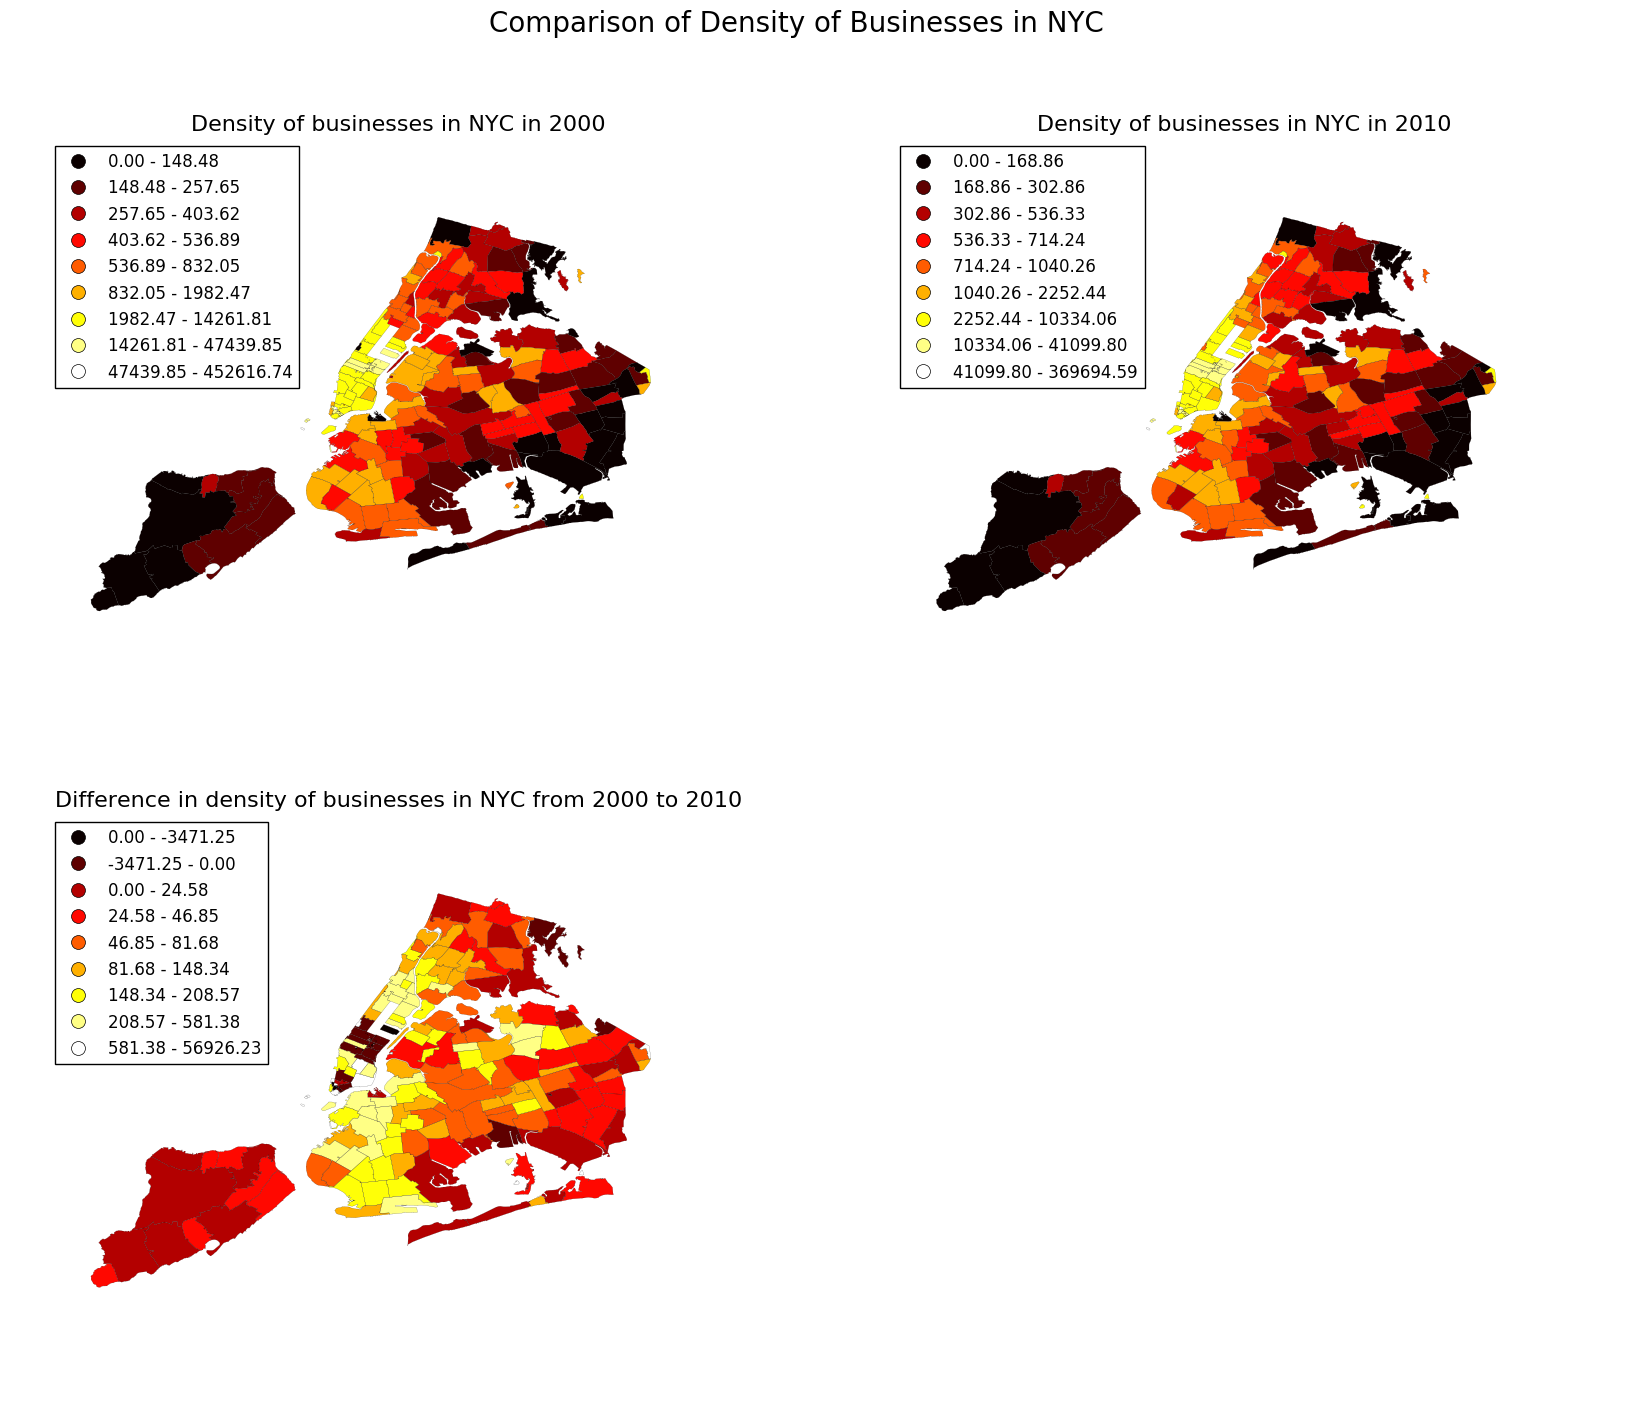

In [16]:
fig = plt.figure(figsize=(20,16))
ax1, ax2, ax3 = fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223)

choropleth_quantiles(zip_codes, column='density_2000',cmap= 'hot', 
                     quantiles= 9, ax=ax1)
ax1.set_title('Density of businesses in NYC in 2000', fontsize = 16)

choropleth_quantiles(zip_codes, column='density_2010',cmap= 'hot', 
                     quantiles= 9, ax=ax2)
ax2.set_title('Density of businesses in NYC in 2010', fontsize = 16)

choropleth_quantiles(zip_codes, column='density_diff',cmap= 'hot', 
                     quantiles= 9, ax=ax3)
ax3.set_title('Difference in density of businesses in NYC from 2000 to 2010', fontsize = 16)

fig.suptitle('Comparison of Density of Businesses in NYC', fontsize = 20)

### Figure 1: Densities of businesses in NYC in 2000 and 2010.
The third map "difference in densities". An increase in business density is seen in areas of Queens, Upper West Side, South Brooklyn. Some areas in mid town, they have lost business.

This is poor proxy for economic growth. This does not weight businesses. Eg. Large company like Google and a small company are weighted equally to quantify economic growth.

# 4) Get census data from the 2010 and 2000 census

In [17]:
# Census 2000 
query = '''SELECT geo_id, 
                  hc01_vc01, 
                  hc02_vc29, 
                  hc01_vc18 
             FROM dec_00_sf1_dp1''' 

datastream = queryCartoDB(query, format='JSON')
datageo  = json.loads(datastream.read())
census00 = gp.GeoDataFrame.from_dict(datageo['rows'])

In [18]:
census00.rename(columns = {"hc01_vc01" : "population_00", 
                           "hc01_vc18" : "age_00",
                           "hc02_vc29" : "diversity_00"}, 
                inplace = True)
census00.head()

geo_id population_00 age_00 diversity_00
0  1400000US36047054300             0    0.0             
1  1400000US36081121100             0    0.0             
2  1400000US36005003700           478   22.0         18.4
3  1400000US36005004900           246   30.0         20.7
4  1400000US36005005800             5   23.5          0.0

In [19]:
# Census 2010
query = '''SELECT geo_id, 
                  hd01_s001, 
                  hd01_s020, 
                  hd02_s078 
             FROM dec_10_sf1_sf1dp1'''

datastream = queryCartoDB(query, format='JSON')
datageo  = json.loads(datastream.read())
census10 = gp.GeoDataFrame.from_dict(datageo['rows'])

In [20]:
census10.rename(columns = {"hd01_s001" : "population_10",
                           "hd01_s020" : "age_10",
                           "hd02_s078" : "diversity_10"}, 
                inplace = True)
# census10 = census10.apply(lambda x: x.str.strip()).replace('', np.nan)
census10.head()

geo_id population_10 age_10 diversity_10
0  1400000US36081038301             0      0             
1  1400000US36005002400             4     38           50
2  1400000US36059990200             0      0             
3  1400000US36059990400             0      0             
4  1400000US36007012900          1532   59.8         98.2

# 5) Get the income data by census tract

In [21]:
# Income Census 2000 
query = '''SELECT geo_id, 
                  hc01_vc64 
             FROM dec_00_sf3_dp3_with_ann'''

datastream = queryCartoDB(query, format='JSON')
datageo  = json.loads(datastream.read())
inc_census00 = gp.GeoDataFrame.from_dict(datageo['rows'])

In [22]:
inc_census00.rename(columns = {"hc01_vc64" : "income_00"}, 
                    inplace = True)
inc_census00.head()

geo_id  income_00
0  1400000US36089991900          0
1  1400000US36001013703      68929
2  1400000US36005000200      42539
3  1400000US36005002400          0
4  1400000US36029001301          0

In [23]:
# Income Census 2010 
query = '''SELECT geo_id, 
                  hc01_est_vc13 
             FROM acs_10_5yr_s1901_with_ann'''

datastream = queryCartoDB(query, format='JSON')
datageo  = json.loads(datastream.read())
inc_census10 = gp.GeoDataFrame.from_dict(datageo['rows'])

In [24]:
inc_census10.rename(columns = {"hc01_est_vc13" : "income_10"}, 
                    inplace = True)
# inc_census10 = inc_census10.apply(lambda x: x.str.strip()).replace('', np.nan)
inc_census10.head()

geo_id income_10
0  1400000US36001000100     32333
1  1400000US36001000200     25354
2  1400000US36001000300     30932
3  1400000US36001000401     60909
4  1400000US36001000403     52807

# 6) Merge the census and income data and plot them

In [25]:
census00 = pd.merge(census00, inc_census00, on = 'geo_id', how = 'inner')
census10 = pd.merge(census10, inc_census10, on = 'geo_id', how = 'inner')

census00.diversity_00 = pd.to_numeric(census00.diversity_00 , errors= 'coerce')
census10.diversity_10 = pd.to_numeric(census10.diversity_10 , errors= 'coerce')

census00.age_00 = pd.to_numeric(census00.age_00 , errors= 'coerce')
census10.age_10 = pd.to_numeric(census10.age_10 , errors= 'coerce')

census00.population_00 = pd.to_numeric(census00.population_00 , errors= 'coerce')
census10.population_10 = pd.to_numeric(census10.population_10 , errors= 'coerce')

census00.income_00 = pd.to_numeric(census00.income_00 , errors= 'coerce')
census10.income_10 = pd.to_numeric(census10.income_10 , errors= 'coerce')

In [26]:
census00.head()

geo_id  population_00  age_00  diversity_00  income_00
0  1400000US36047054300              0     0.0           NaN          0
1  1400000US36081121100              0     0.0           NaN          0
2  1400000US36005003700            478    22.0          18.4      23750
3  1400000US36005004900            246    30.0          20.7      25662
4  1400000US36005005800              5    23.5           0.0       6250

In [27]:
census10.head()

geo_id  population_10  age_10  diversity_10  income_10
0  1400000US36081038301              0     0.0           NaN        NaN
1  1400000US36005002400              4    38.0          50.0        NaN
2  1400000US36059990200              0     0.0           NaN        NaN
3  1400000US36059990400              0     0.0           NaN        NaN
4  1400000US36007012900           1532    59.8          98.2    58523.0

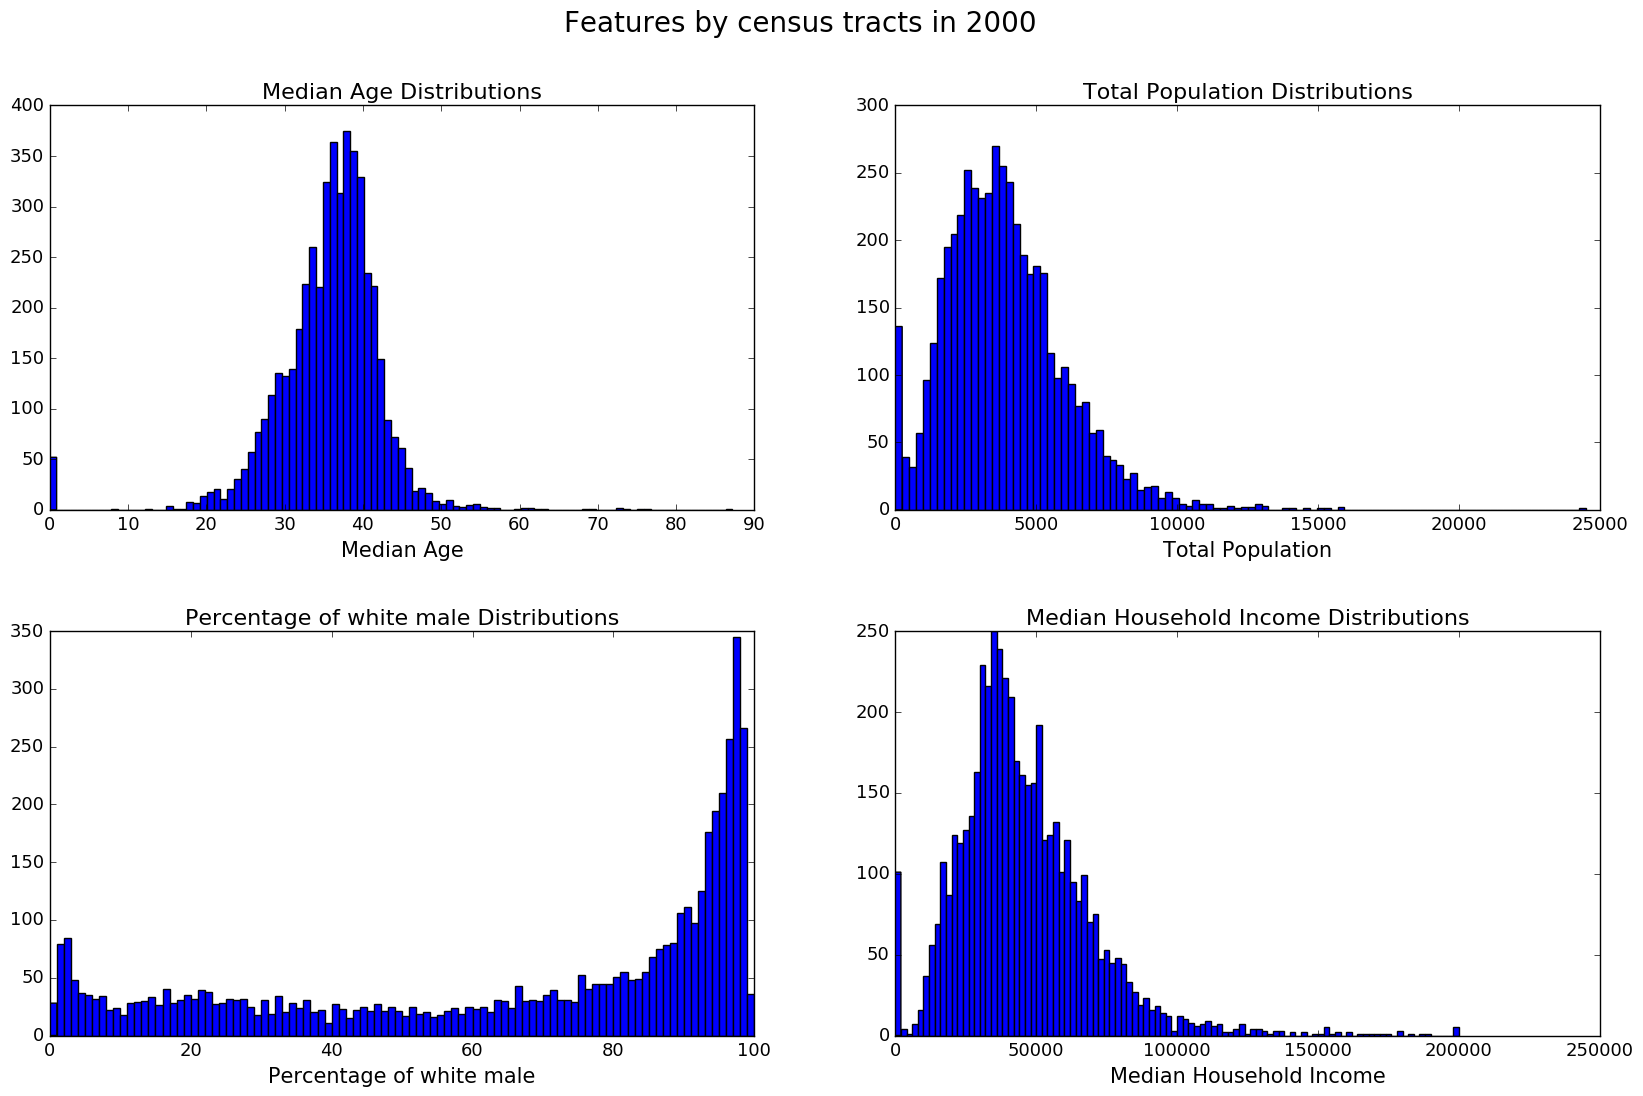

In [28]:
fig = plt.figure(figsize=(20,12))
ax1, ax2 = fig.add_subplot(221), fig.add_subplot(222) 
ax3, ax4 = fig.add_subplot(223), fig.add_subplot(224)
pl.subplots_adjust(hspace=0.3)

ax1 = census00.age_00.hist(ax=ax1, grid= False, xlabelsize=13, ylabelsize=13,
                           bins= 100)
ax1.set_title('Median Age Distributions', fontsize = 16)
ax1.set_xlabel('Median Age', fontsize = 15)

ax2 = census00.population_00.hist(ax=ax2, grid= False, xlabelsize=13, ylabelsize=13,
                                  bins= 100)
ax2.set_title('Total Population Distributions', fontsize = 16)
ax2.set_xlabel('Total Population', fontsize = 15)

ax3 = census00.diversity_00.hist(ax=ax3, grid= False, xlabelsize=13, ylabelsize=13,
                           bins= 100)
ax3.set_title('Percentage of white male Distributions', fontsize = 16)
ax3.set_xlabel('Percentage of white male', fontsize = 15)

ax4 = census00.income_00.hist(ax=ax4, grid= False, xlabelsize=13, ylabelsize=13,
                           bins= 100)
ax4.set_title('Median Household Income Distributions', fontsize = 16)
ax4.set_xlabel('Median Household Income', fontsize = 15)

fig.suptitle('Features by census tracts in 2000', fontsize = 20)

### Figure 2: Histograms of the features in 2000
The median age is around 35 yrs. The mean population in census tracts is around 4000 and the distribution is skewed towards right indicating, some census tracts have larger populations as well. The mean value of percentage of white people in census tracts is less than the median value. The mean median household income in nyc census tracts is around 45000.     

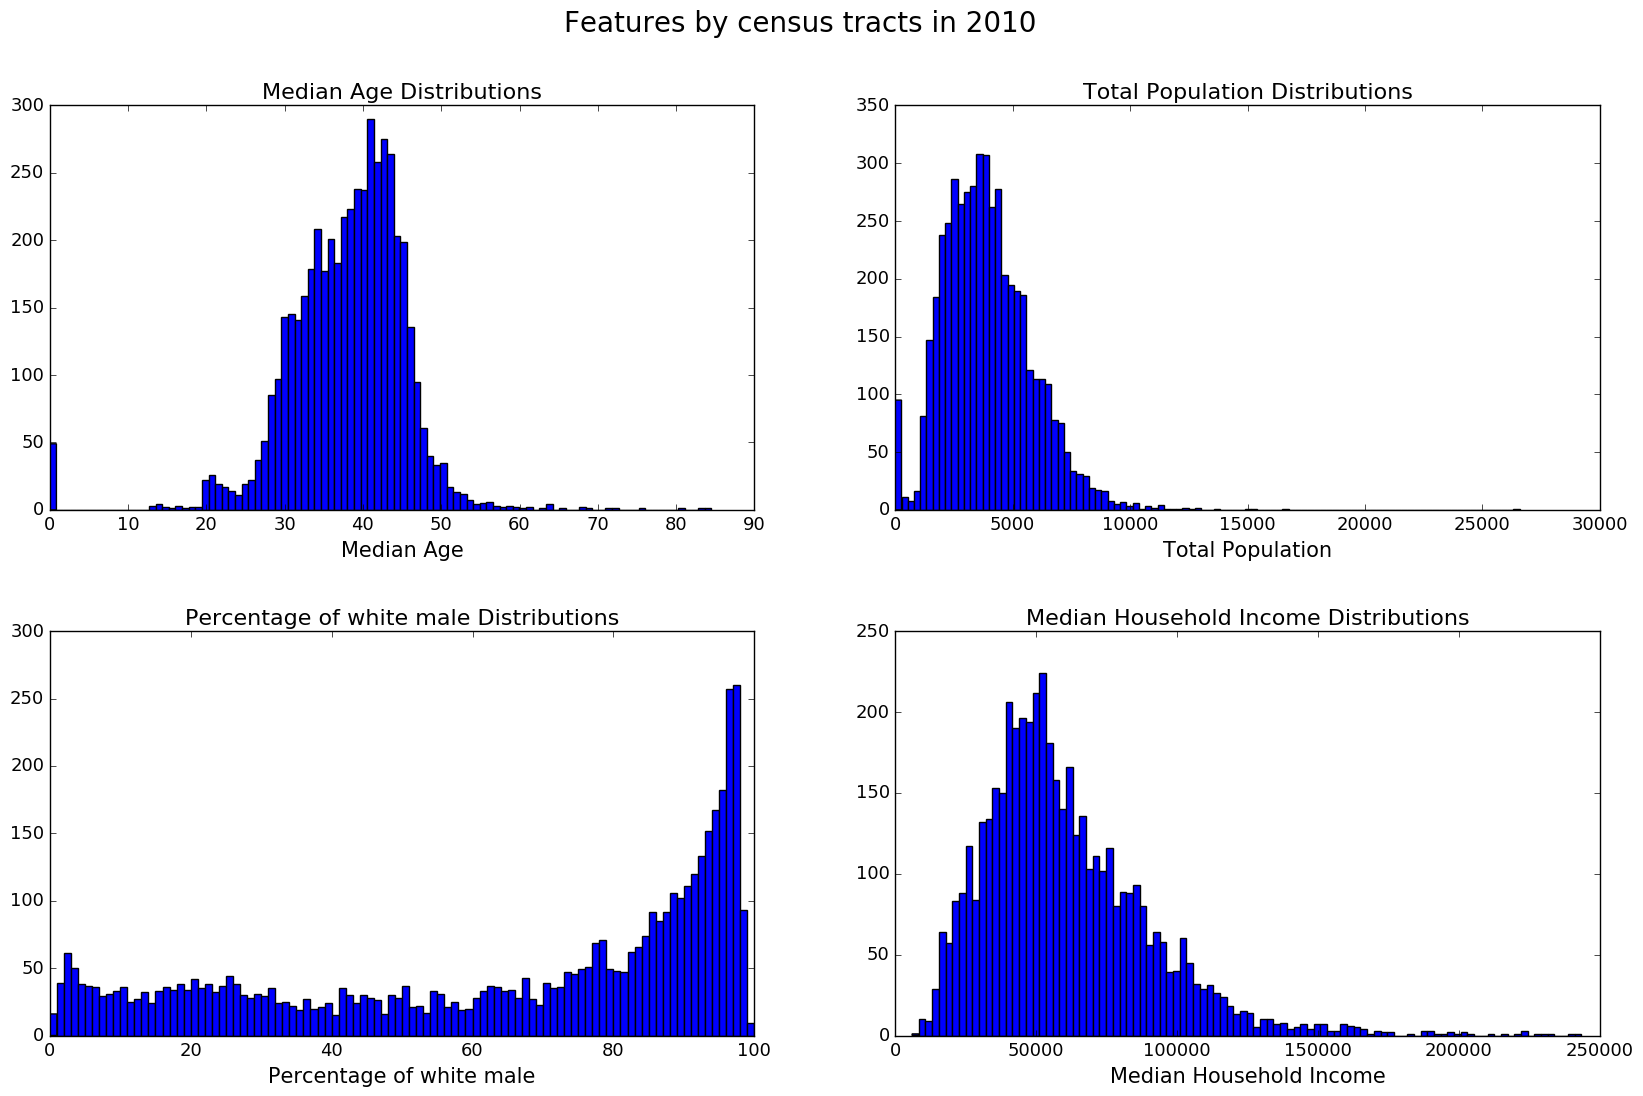

In [29]:
fig = plt.figure(figsize=(20,12))
ax1, ax2 = fig.add_subplot(221), fig.add_subplot(222) 
ax3, ax4 = fig.add_subplot(223), fig.add_subplot(224)
pl.subplots_adjust(hspace=0.3)

ax1 = census10.age_10.hist(ax=ax1, grid= False, xlabelsize=13, ylabelsize=13,
                           bins= 100)
ax1.set_title('Median Age Distributions', fontsize = 16)
ax1.set_xlabel('Median Age', fontsize = 15)

ax2 = census10.population_10.hist(ax=ax2, grid= False, xlabelsize=13, ylabelsize=13,
                                  bins= 100)
ax2.set_title('Total Population Distributions', fontsize = 16)
ax2.set_xlabel('Total Population', fontsize = 15)

ax3 = census10.diversity_10.hist(ax=ax3, grid= False, xlabelsize=13, ylabelsize=13,
                           bins= 100)
ax3.set_title('Percentage of white male Distributions', fontsize = 16)
ax3.set_xlabel('Percentage of white male', fontsize = 15)

ax4 = census10.income_10.hist(ax=ax4, grid= False, xlabelsize=13, ylabelsize=13,
                           bins= 100)
ax4.set_title('Median Household Income Distributions', fontsize = 16)
ax4.set_xlabel('Median Household Income', fontsize = 15)

fig.suptitle('Features by census tracts in 2010', fontsize = 20)

### Figure 3: Histograms of the features in 2010
The median age is around 37 yrs. The mean population in census tracts is around 4000 and the distribution is skewed towards right indicating, some census tracts have larger populations as well. The mean value of percentage of white people in census tracts is smaller than the median value. The mean median household income in nyc census tracts is around 55000 which is greater than the median income in 2000.     

# 7) Merge census tracts shapefile and census data  and display choropleth maps

## Get Census Tracts shapefile

In [30]:
query = '''SELECT * 
           FROM table_2010_census_tracts''' 

datastream = queryCartoDB(query, format='GeoJSON')
datageo  = json.loads(datastream.read())
ct_shape = gp.GeoDataFrame.from_features(datageo['features'])

In [31]:
countyID = {'Bronx':'005',
           'Manhattan':'061',
           'Staten Island':'085',
           'Brooklyn':'047',
           'Queens':'081'}

ct_shape['allcodes'] = list(zip(ct_shape.boro_name, ct_shape.ct_2010))
ct_shape['geo_id']  = ct_shape[['allcodes']].applymap(lambda x: 
                            ("1400000US36%03d%06d"%(int(countyID[x[0]]),int(x[1]))))

In [32]:
ct_shape.drop(['boro_code', 'boro_ct_2010', 'boro_name', 'cartodb_id',
               'cdeligibil', 'ct_2010', 'ctlabel', 'ntacode', 'allcodes',
               'ntaname', 'puma', 'shape_area', 'shape_leng'], axis = 1,
             inplace = True)

## Merge census tracts shapefile and census files

In [33]:
census_merged = pd.merge(ct_shape, census00, on='geo_id', how='left')
census_merged = pd.merge(census_merged, census10, on='geo_id', how='left')

In [34]:
census_merged.loc[:,'age_diff'] = census_merged.loc[:,'age_10'] - census_merged.loc[:,'age_00']
census_merged.loc[:,'income_diff'] = census_merged.loc[:,'income_10']  - census_merged.loc[:,'income_00']
census_merged.loc[:,'diversity_diff'] = census_merged.loc[:,'diversity_10'] - census_merged.loc[:,'diversity_00']
census_merged.loc[:,'population_diff'] = census_merged.loc[:,'population_10']  - census_merged.loc[:,'population_00']

## Plot the choropleth

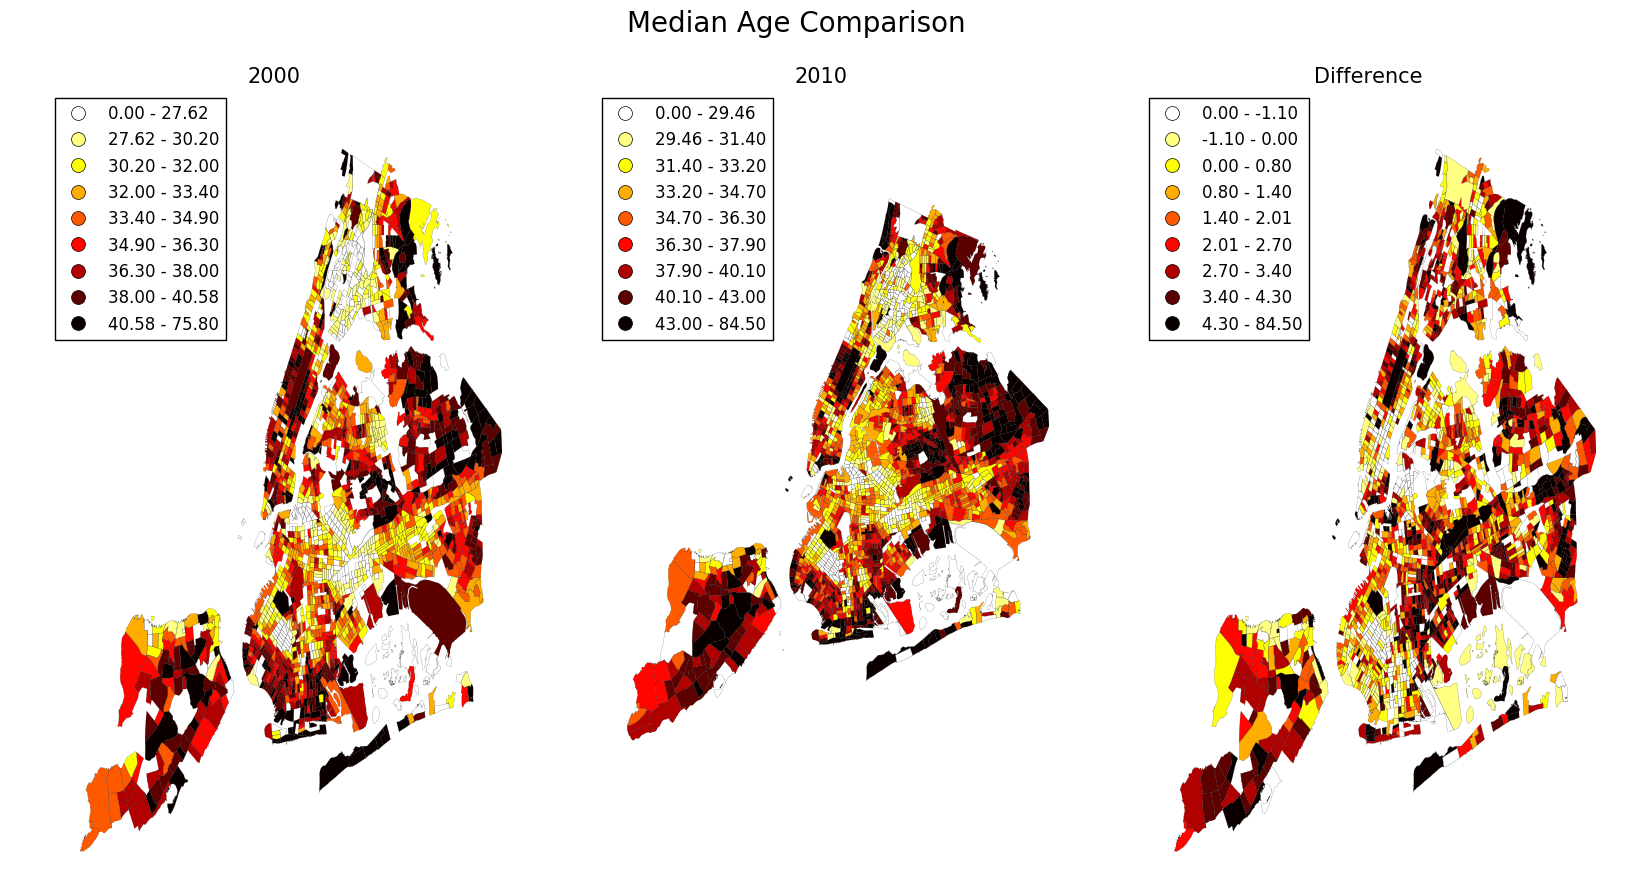

In [35]:
fig = plt.figure(figsize=(20,10))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133) 
choropleth_quantiles(census_merged[census_merged.age_00.notnull()],column ='age_00', 
                     quantiles = 9, cmap='hot_r',ax= ax1)
ax1.set_title('2000', fontsize = 15)

choropleth_quantiles(census_merged[census_merged.age_10.notnull()],column ='age_10', 
                     quantiles = 9, cmap='hot_r',ax= ax2)
ax2.set_title('2010', fontsize = 15)

choropleth_quantiles(census_merged[census_merged.age_diff.notnull()],column ='age_diff', 
                     quantiles = 9, cmap='hot_r',ax= ax3)
ax3.set_title('Difference', fontsize = 15)

fig.suptitle('Median Age Comparison', fontsize = 20)

### Figure 4: Median Age Changes from 2000 to 2010.
The median age in areas around south brooklyn, downtown brooklyn, columbia university is young, this maybe because most of the college students live around those areas. The median age in Staten Island is around 40, this maybe because mostly families live in Staten island
Median age increase is observed in areas of Upper west side Manhattan, some areas of Midtown, Manhattan and north part of Queens. However, some missing census tracts are leading to incorrect representations of the age difference.

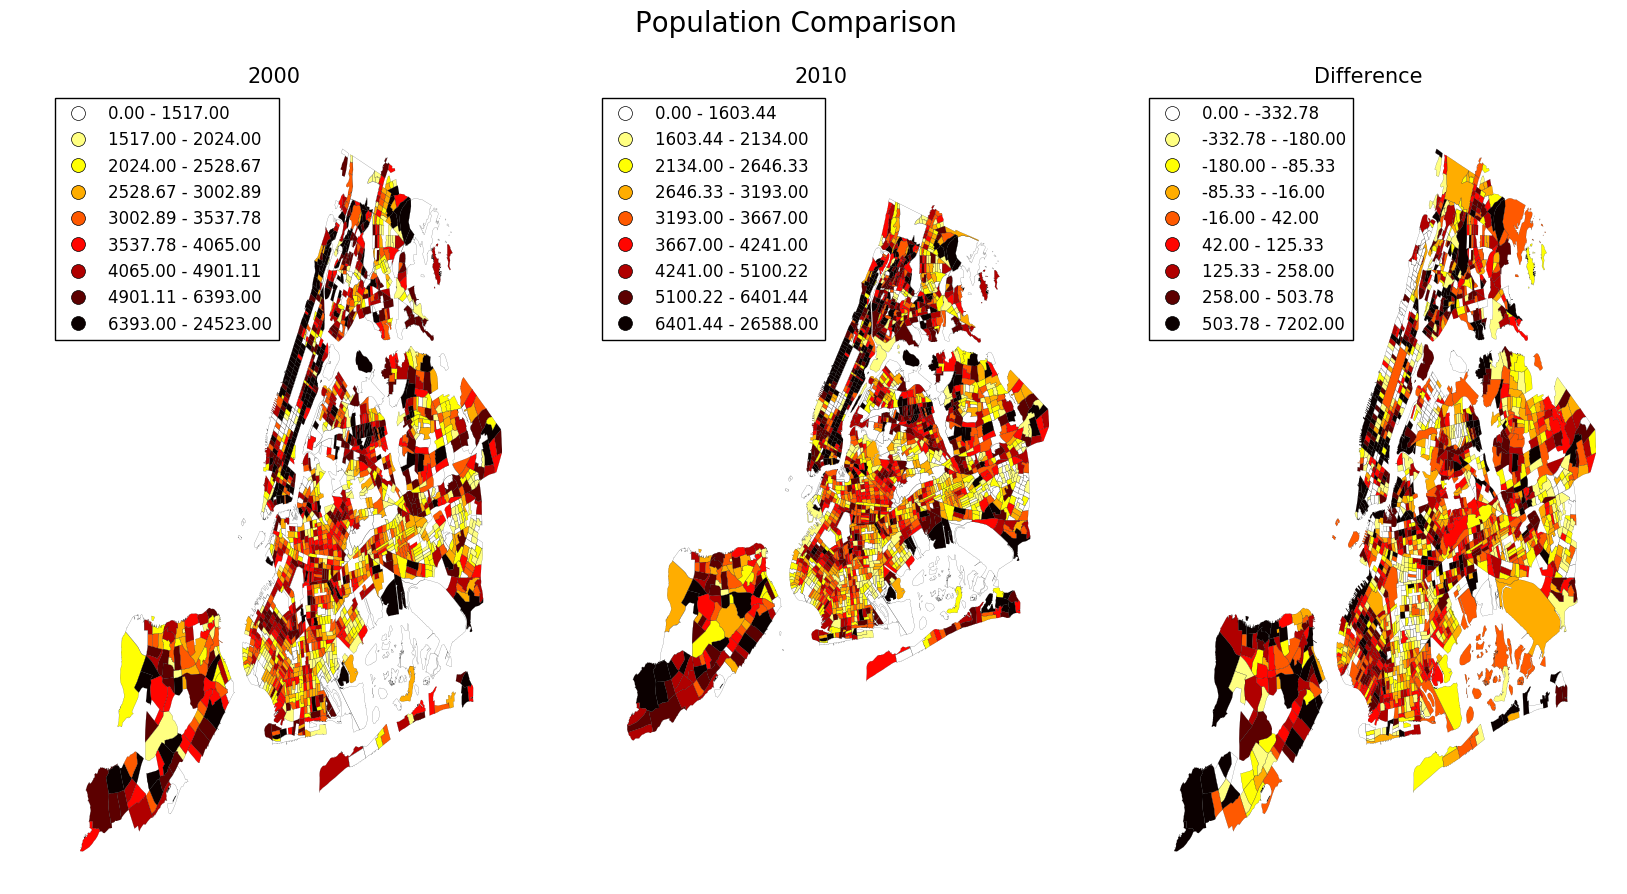

In [36]:
fig = plt.figure(figsize=(20,10))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133) 
choropleth_quantiles(census_merged[census_merged.population_00.notnull()],column ='population_00', 
                     quantiles = 9, cmap='hot_r',ax= ax1)
ax1.set_title('2000', fontsize = 15)

choropleth_quantiles(census_merged[census_merged.population_10.notnull()],column ='population_10', 
                     quantiles = 9, cmap='hot_r',ax= ax2)
ax2.set_title('2010', fontsize = 15)

choropleth_quantiles(census_merged[census_merged.population_diff.notnull()],column ='population_diff', 
                     quantiles = 9, cmap='hot_r',ax= ax3)
ax3.set_title('Difference', fontsize = 15)

fig.suptitle('Population Comparison', fontsize = 20)

### Figure 5: Population Change by census tracts from 2000 to 2010
Population increase is observed in census tracts near midtown Manhattan, lower Manhattan, some areas near Sunset park, Bayridge in Brooklyn. Some missing census tracts are leading to incorrect representations of the population difference.

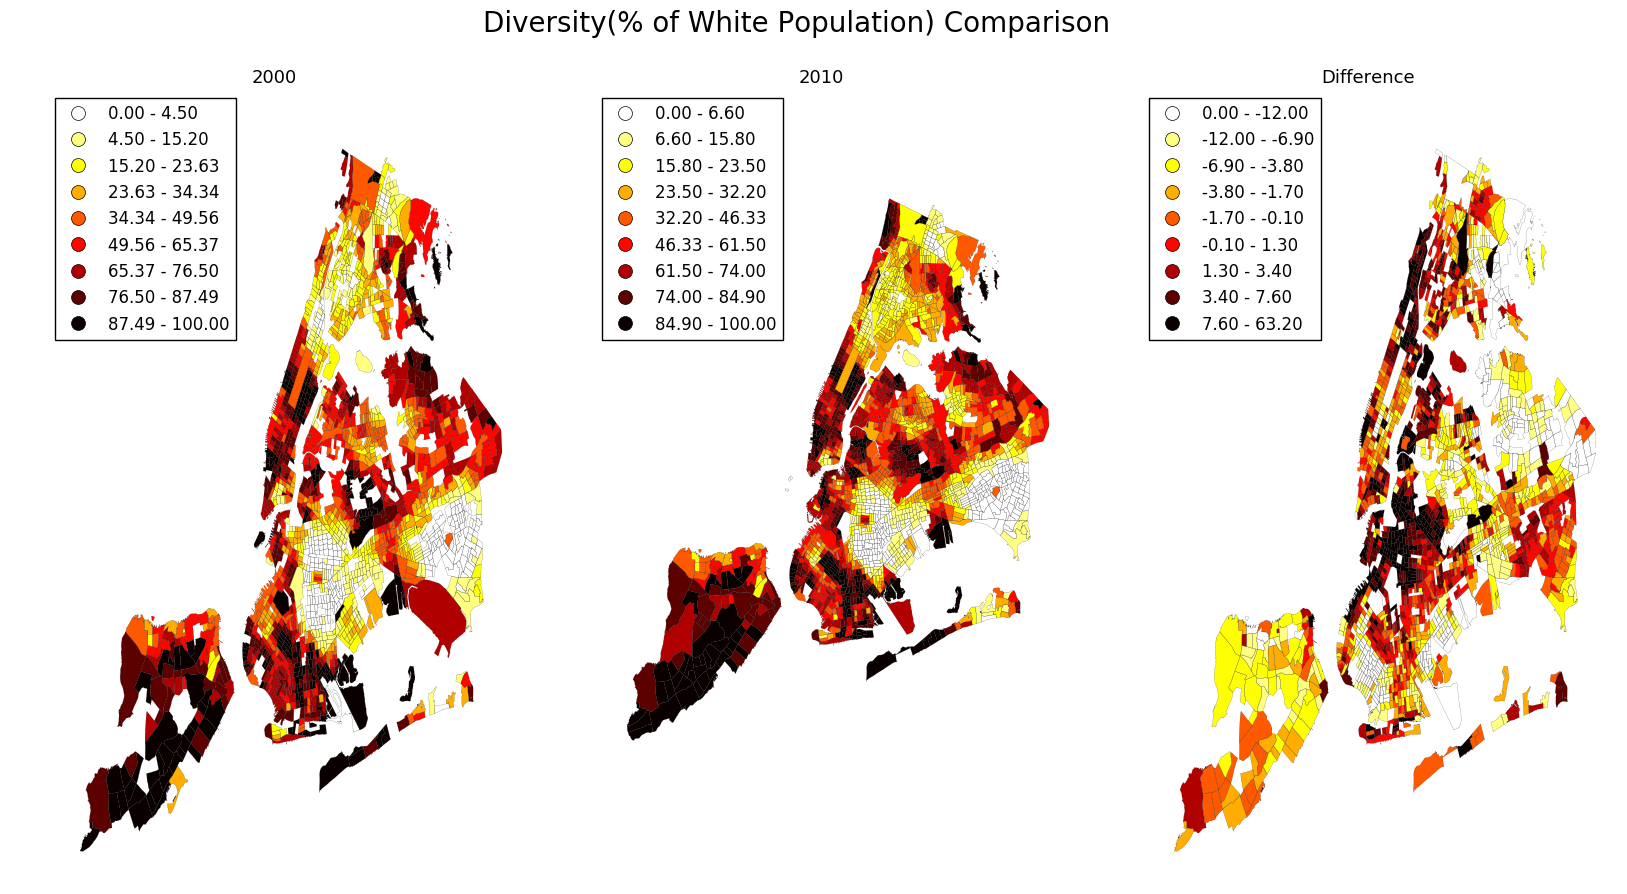

In [37]:
fig = plt.figure(figsize=(20,10))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133) 
choropleth_quantiles(census_merged[census_merged.diversity_00.notnull()],column ='diversity_00', 
                     quantiles = 9, cmap='hot_r',ax= ax1)
ax1.set_title('2000', fontsize = 13)

choropleth_quantiles(census_merged[census_merged.diversity_10.notnull()],column ='diversity_10', 
                     quantiles = 9, cmap='hot_r',ax= ax2)
ax2.set_title('2010', fontsize = 13)

choropleth_quantiles(census_merged[census_merged.diversity_diff.notnull()],column ='diversity_diff', 
                     quantiles = 9, cmap='hot_r',ax= ax3)
ax3.set_title('Difference', fontsize = 13)

fig.suptitle('Diversity(% of White Population) Comparison', fontsize = 20)

### Figure 6: % White Population Change by census tracts from 2000 to 2010
% of White Population increase is observed in some census tracts near midtown Manhattan, areas near downtown Brooklyn. White population decrease is observed near upper west and east side of Manhattan. Some missing census tracts are leading to incorrect representations of the white population difference.

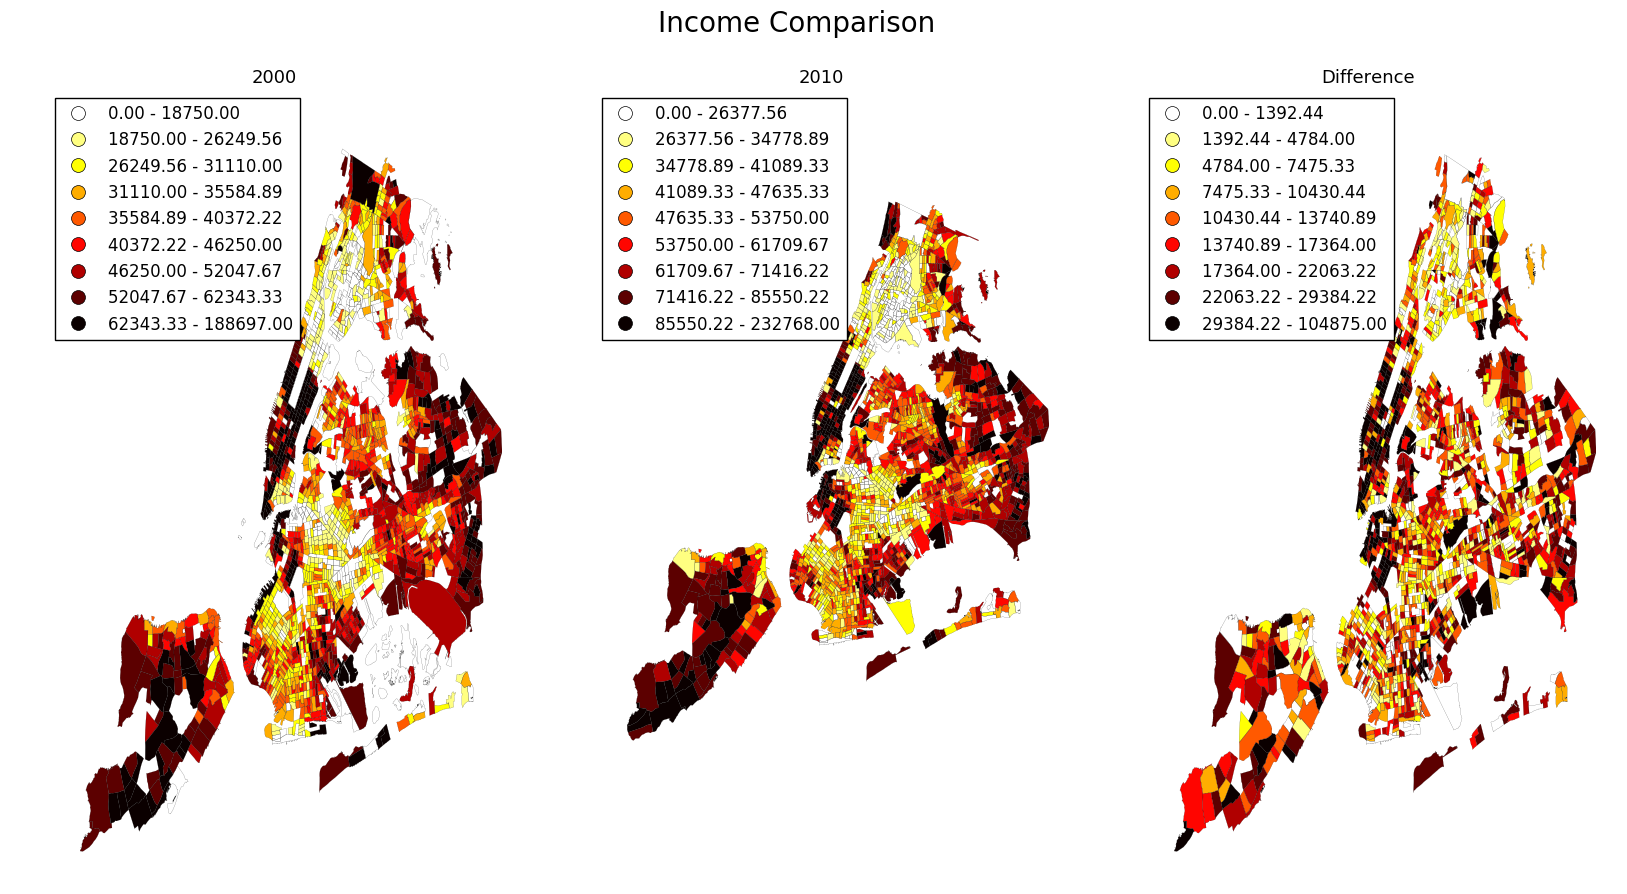

In [38]:
fig = plt.figure(figsize=(20,10))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133) 
choropleth_quantiles(census_merged[census_merged.income_00.notnull()],column ='income_00', 
                     quantiles = 9, cmap='hot_r',ax= ax1)
ax1.set_title('2000', fontsize = 13)

choropleth_quantiles(census_merged[census_merged.income_10.notnull()],column ='income_10', 
                     quantiles = 9, cmap='hot_r',ax= ax2)
ax2.set_title('2010', fontsize = 13)

choropleth_quantiles(census_merged[census_merged.income_diff.notnull()],column ='income_diff', 
                     quantiles = 9, cmap='hot_r',ax= ax3)
ax3.set_title('Difference', fontsize = 13)

fig.suptitle('Income Comparison', fontsize = 20)

### Figure 7: Median Income Change by census tracts from 2000 to 2010
Median income increase is observed in some census tracts near midtown Manhattan, lower Manhattan, upper west, east side, areas near downtown Brooklyn. Some missing census tracts are leading to incorrect representations of the white population difference.

# 8) Cluster the census tracts

## Cleaning the data for clustering

In [39]:
census2000 = census_merged.as_matrix(columns=['age_00', 'population_00', 'diversity_00', 'income_00'])
census2010 = census_merged.as_matrix(columns=['age_10', 'population_10', 'diversity_10', 'income_10'])

In [40]:
# Removing Nan's
clean2000 = census2000[std(census2000, axis= 1)>0]
clean2010 = census2010[std(census2010, axis= 1)>0]

cleannyct00 = np.array(census_merged.geo_id)[std(census2000, 1)>0]
cleannyct10 = np.array(census_merged.geo_id)[std(census2010, 1)>0]
# badzips =  np.where(~(std(clean2000, 1)>0))[0]

In [41]:
# Whitening the data
wcencus00 = whiten(clean2000)
wcencus10 = whiten(clean2010)

## Clustering

In [42]:
nc = 5
km00 = KMeans(nc, random_state=444)
km00.fit(wcencus00)

clusters00 = gp.GeoDataFrame()
clusters00['geo_id'] = cleannyct00
clusters00['cluster00'] = km00.labels_

census_cluster = pd.merge(census_merged, clusters00, on='geo_id', how='left')

In [43]:
nc = 5
km10 = KMeans(n_clusters=nc, init= km00.cluster_centers_, random_state=444)
km10.fit(wcencus10)

clusters10 = gp.GeoDataFrame()
clusters10['geo_id'] = cleannyct10
clusters10['cluster10'] = km10.labels_

census_cluster = pd.merge(census_cluster, clusters10, on='geo_id', how='left')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:821: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  n_jobs=self.n_jobs)


# 9) Identify the census tracts that have changed cluster assignment and plot

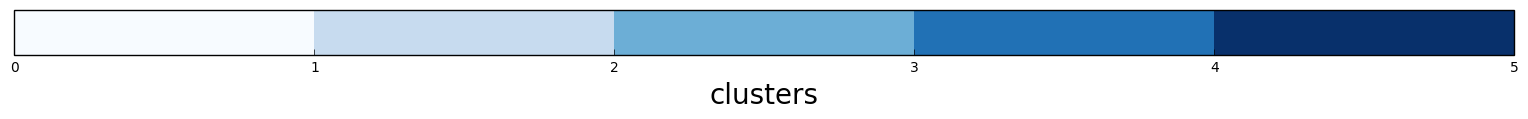

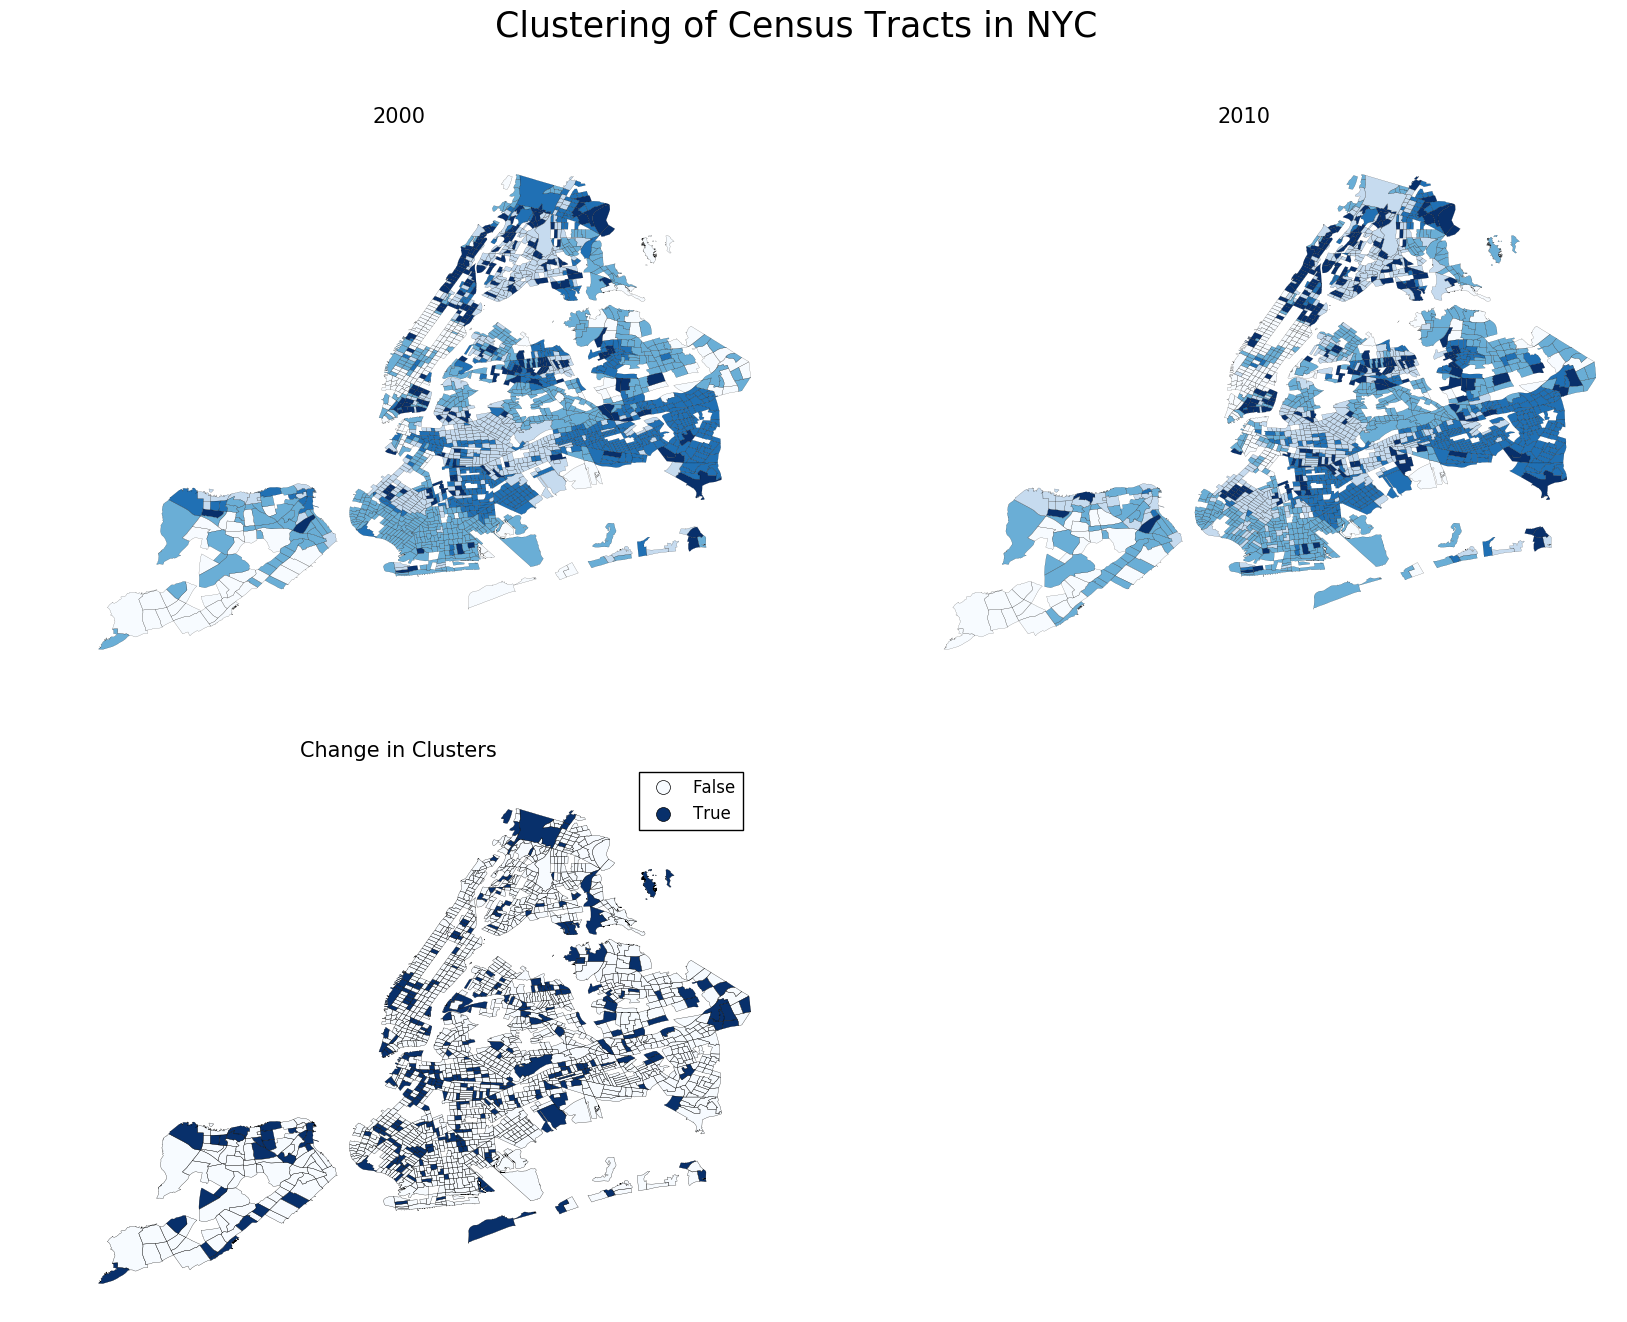

In [44]:
census_cluster.dropna(inplace= True)
census_cluster['change'] = census_cluster.cluster00 != census_cluster.cluster10

# Code taken from fb55
fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=5)

bounds = range(nc + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='horizontal')
cb3.set_label('clusters', fontsize=20)

fig = plt.figure(figsize=(20,15))
ax2, ax3, ax4 = fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223)

census_cluster[census_cluster.cluster00.notnull()].plot(column='cluster00', 
                                              cmap='Blues', alpha = 1, linewidth=0.1, ax=ax2)
ax2.axis('off')
ax2.set_title('2000', fontsize=15)

census_cluster[census_cluster.cluster10.notnull()].plot(column='cluster10', 
                                              cmap='Blues', alpha = 1, linewidth=0.1, ax=ax3)
ax3.axis('off')
ax3.set_title('2010', fontsize=15)

census_cluster.plot(categorical = True, column = 'change', alpha = 1, linewidth=0.2, 
                    cmap='Blues', ax= ax4, legend = True)
ax4.set_axis_off()
ax4.set_title('Change in Clusters', fontsize=15)

fig.suptitle('Clustering of Census Tracts in NYC', fontsize = 25)

### Figure 8: Clustering of the census tracts depending on income, diversity, population, age features.
The census tracts are clustered into 5 groups. Some census tracts change cluster in 2010. The third figure shows the census tracts who changed clustered. The census tracts around midtown Manhattan near High-line, Downtown Brooklyn have changed. 

In [45]:
print 'Count of census tracts which changed :\n', census_cluster.change.sum()

Count of census tracts which changed :
334


# 10)  Aggregate the features at census tract to zipcode level

In [46]:
census_cluster.crs = from_epsg(4326)
census_cluster['centroid'] = census_cluster.geometry.centroid

In [47]:
cluster = census_cluster[[u'geo_id', u'population_00', u'age_00', u'diversity_00',
                          u'income_00', u'population_10', u'age_10', u'diversity_10',
                          u'income_10', u'age_diff', u'income_diff', u'diversity_diff',
                          u'population_diff', u'centroid']]

In [48]:
cluster.rename(columns={'centroid':'geometry'}, inplace= True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


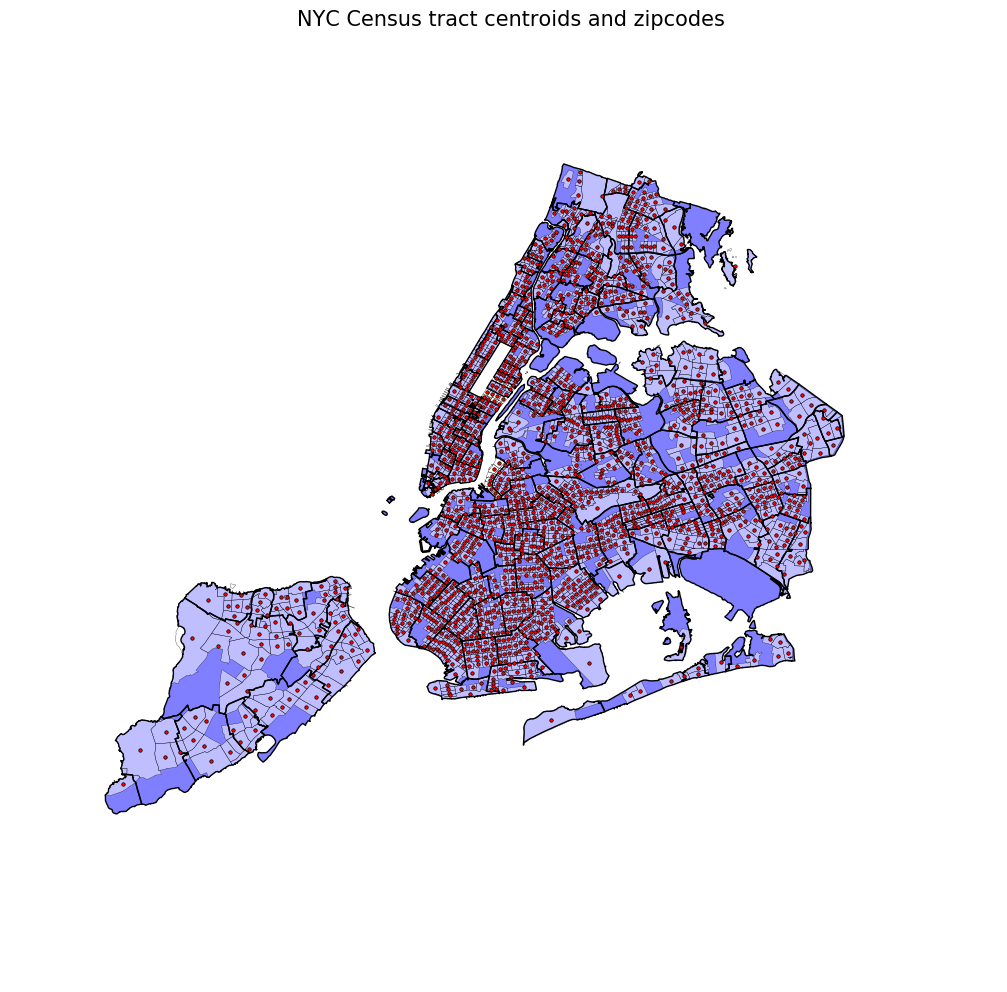

In [49]:
fig, ax = plt.subplots(figsize=(12,12))
zip_codes.plot(ax=ax, color='blue', linewidth = 1)
census_cluster.plot(ax=ax, color='white', linewidth = 0.2)
gp.GeoDataFrame(cluster).plot(ax=ax, marker='o', color='red', markersize=2.5)
ax.set_axis_off()
ax.set_title('NYC Census tract centroids and zipcodes', fontsize = 15)

### Figure 9: Map of NYC showing the census tract centroids and zipcodes. 
The dark-blue areas are the missing census tracts from the census dataset, the red dots are the centroids of the available census tracts(light-blue) in the current Geodataframe. The black line denotes the boundaries of the zip-codes. When we spatially merge the census tracts to the zipcodes, zipcode which contain missing census tracts and available census tracts will have attributes from only avaliable census tracts. This create a bias in the features.

In [50]:
zip_ct = gp.sjoin(cluster, zip_codes)

In [51]:
zip_conciled = zip_ct.groupby('ZIPCODE').agg({'age_00':'mean', 'diversity_00':'mean', 
                                              'income_00':'mean', 'population_00':'mean',
                                              'age_10':'mean', 'diversity_10':'mean',
                                              'income_10':'mean', 'population_10':'mean', 
                                              'age_diff':'mean','diversity_diff':'mean', 
                                              'population_diff':'mean', 'income_diff':'mean',
                                              'density_2000':'first','density_2010': 'first',
                                              'density_diff':'first'}).reset_index()         

In [52]:
zip_conciled = gp.GeoDataFrame(pd.merge(zip_conciled , zip_codes[['ZIPCODE', 'geometry']], on= 'ZIPCODE', how='inner'))

# 11 - a) Display choropleth maps of features

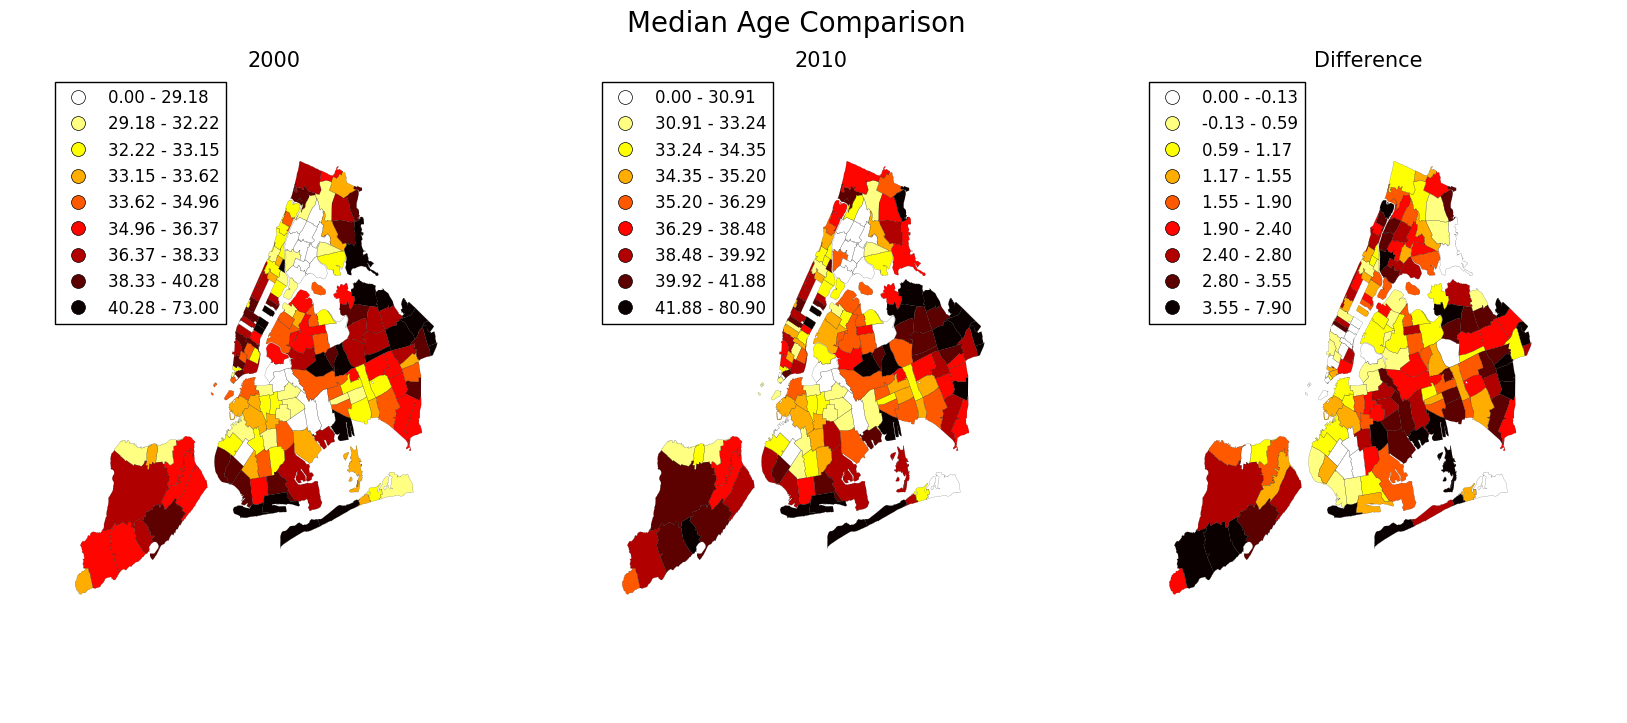

In [53]:
fig = plt.figure(figsize=(20,8))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133) 
choropleth_quantiles(zip_conciled[zip_conciled.age_00.notnull()],column ='age_00', 
                     quantiles = 9, cmap='hot_r',ax= ax1)
ax1.set_title('2000', fontsize = 15)

choropleth_quantiles(zip_conciled[zip_conciled.age_10.notnull()],column ='age_10', 
                     quantiles = 9, cmap='hot_r',ax= ax2)
ax2.set_title('2010', fontsize = 15)

choropleth_quantiles(zip_conciled[zip_conciled.age_diff.notnull()],column ='age_diff', 
                     quantiles = 9, cmap='hot_r',ax= ax3)
ax3.set_title('Difference', fontsize = 15)

fig.suptitle('Median Age Comparison', fontsize = 20)

### Figure 10: Median Age Change by zip code from 2000 to 2010.
The median age in areas around downtown brooklyn is young, this maybe because most of the college students live around those areas. The median age in Staten Island is around 40, this maybe because mostly families live in Staten island.
Median age increase is observed in areas of Upper west side Manhattan, some areas of Midtown, Manhattan and north part of Queens. The missing census tracts which have been joined to the zip-codes are also creating some mis-representations

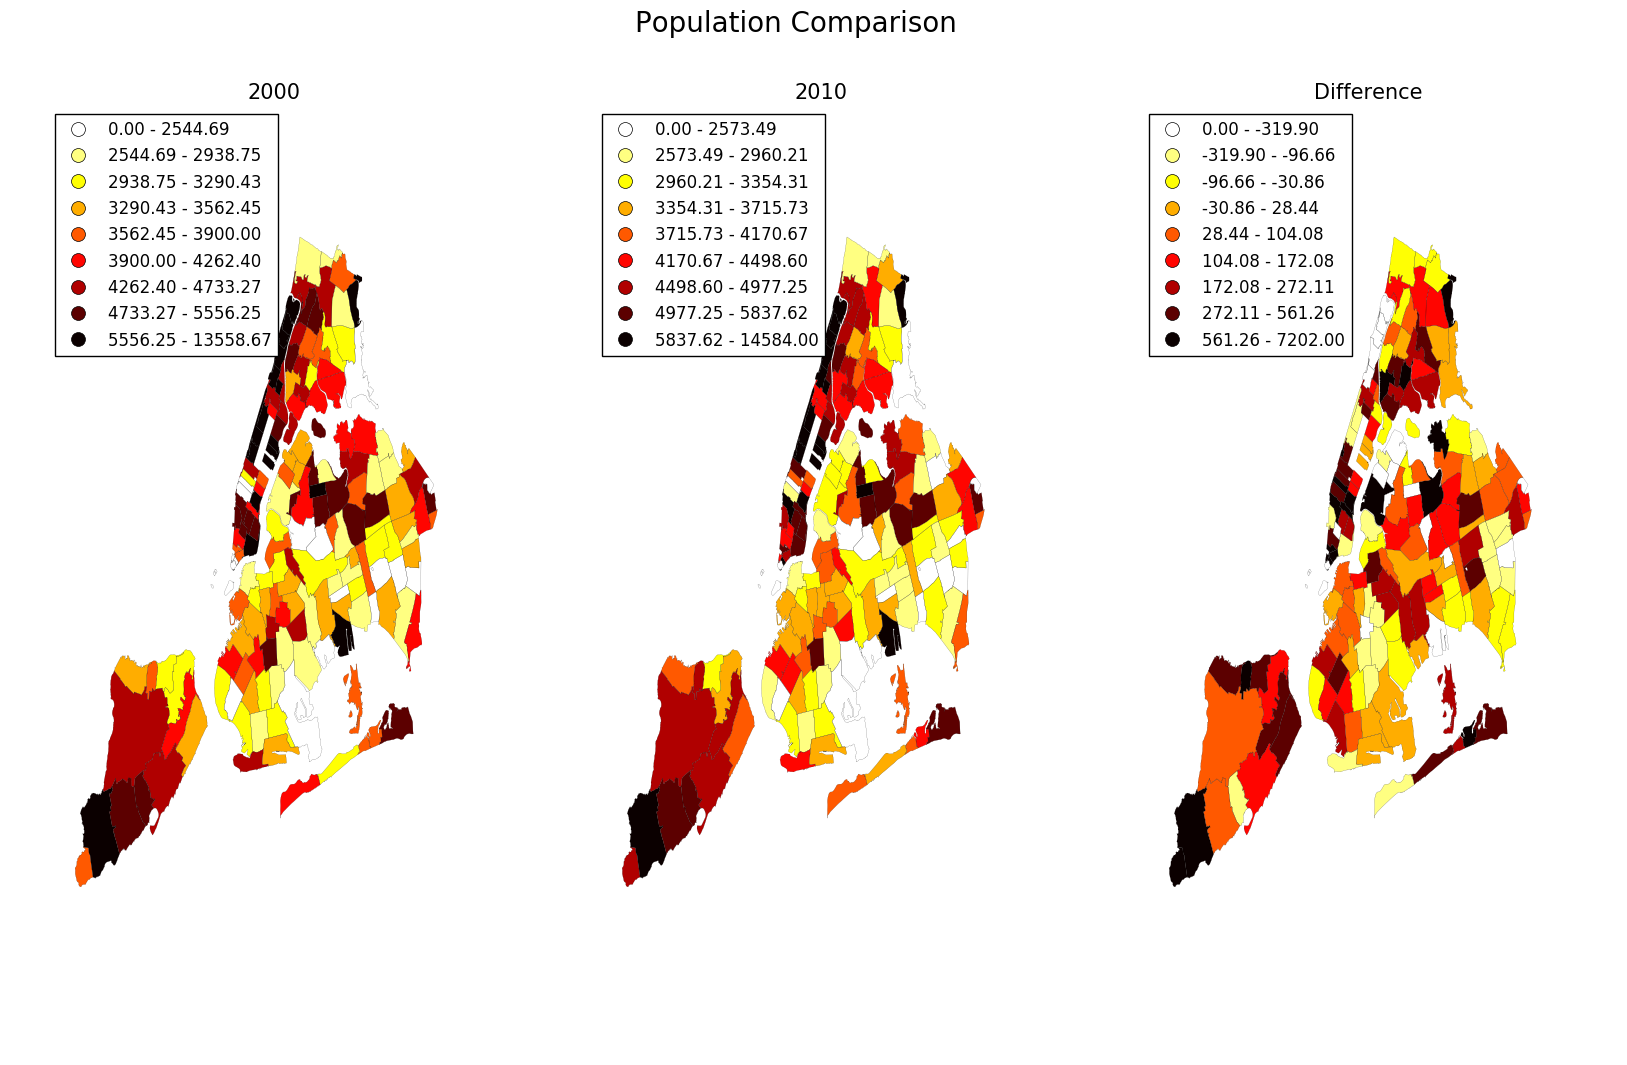

In [54]:
fig = plt.figure(figsize=(20,12))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133) 
choropleth_quantiles(zip_conciled[zip_conciled.population_00.notnull()],column ='population_00', 
                     quantiles = 9, cmap='hot_r',ax= ax1)
ax1.set_title('2000', fontsize = 15)

choropleth_quantiles(zip_conciled[zip_conciled.population_10.notnull()],column ='population_10', 
                     quantiles = 9, cmap='hot_r',ax= ax2)
ax2.set_title('2010', fontsize = 15)

choropleth_quantiles(zip_conciled[zip_conciled.population_diff.notnull()],column ='population_diff', 
                     quantiles = 9, cmap='hot_r',ax= ax3)
ax3.set_title('Difference', fontsize = 15)

fig.suptitle('Population Comparison', fontsize = 20)

### Figure 11: Population Change by zip codes from 2000 to 2010
Population increase is observed in census tracts near midtown Manhattan, lower Manhattan, some areas near Sunset park, Bayridge in Brooklyn and parts of staten island

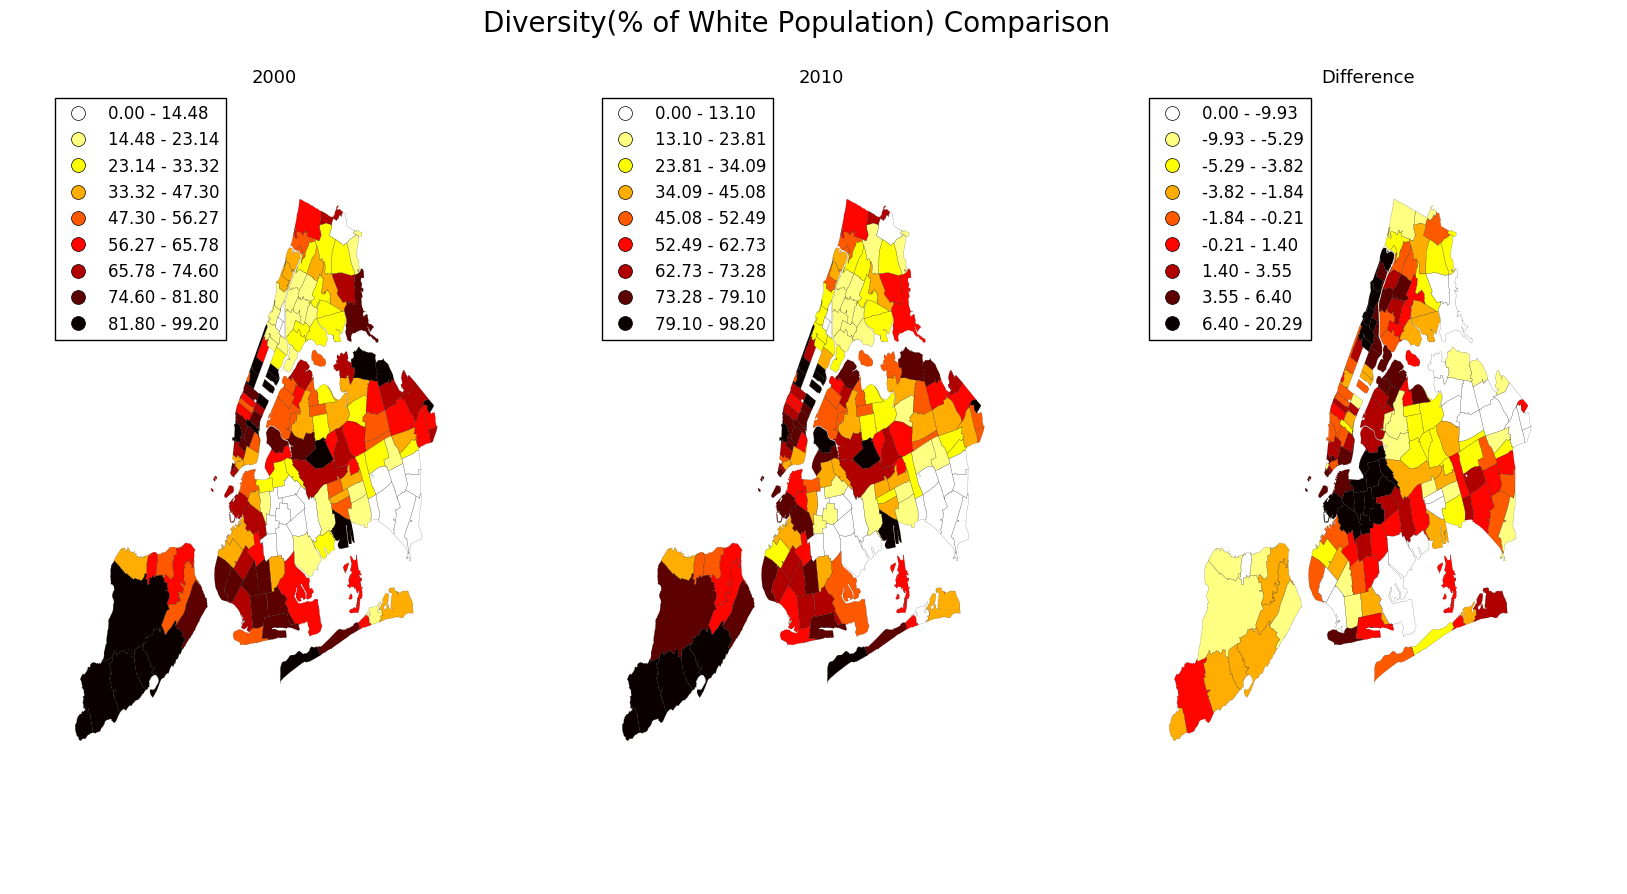

In [55]:
fig = plt.figure(figsize=(20,10))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133) 
choropleth_quantiles(zip_conciled[zip_conciled.diversity_00.notnull()],column ='diversity_00', 
                     quantiles = 9, cmap='hot_r',ax= ax1)
ax1.set_title('2000', fontsize = 13)

choropleth_quantiles(zip_conciled[zip_conciled.diversity_10.notnull()],column ='diversity_10', 
                     quantiles = 9, cmap='hot_r',ax= ax2)
ax2.set_title('2010', fontsize = 13)

choropleth_quantiles(zip_conciled[zip_conciled.diversity_diff.notnull()],column ='diversity_diff', 
                     quantiles = 9, cmap='hot_r',ax= ax3)
ax3.set_title('Difference', fontsize = 13)

fig.suptitle('Diversity(% of White Population) Comparison', fontsize = 20)

### Figure 12: Percentage of White Population Change by zip codes from 2000 to 2010
% of White Population increase is observed in some zipcodes near downtown Brooklyn. White population decrease is observed near upper west and east side of Manhattan. More percentage of white population is in Staten Island, i.e there is less diversity in areas with more white population

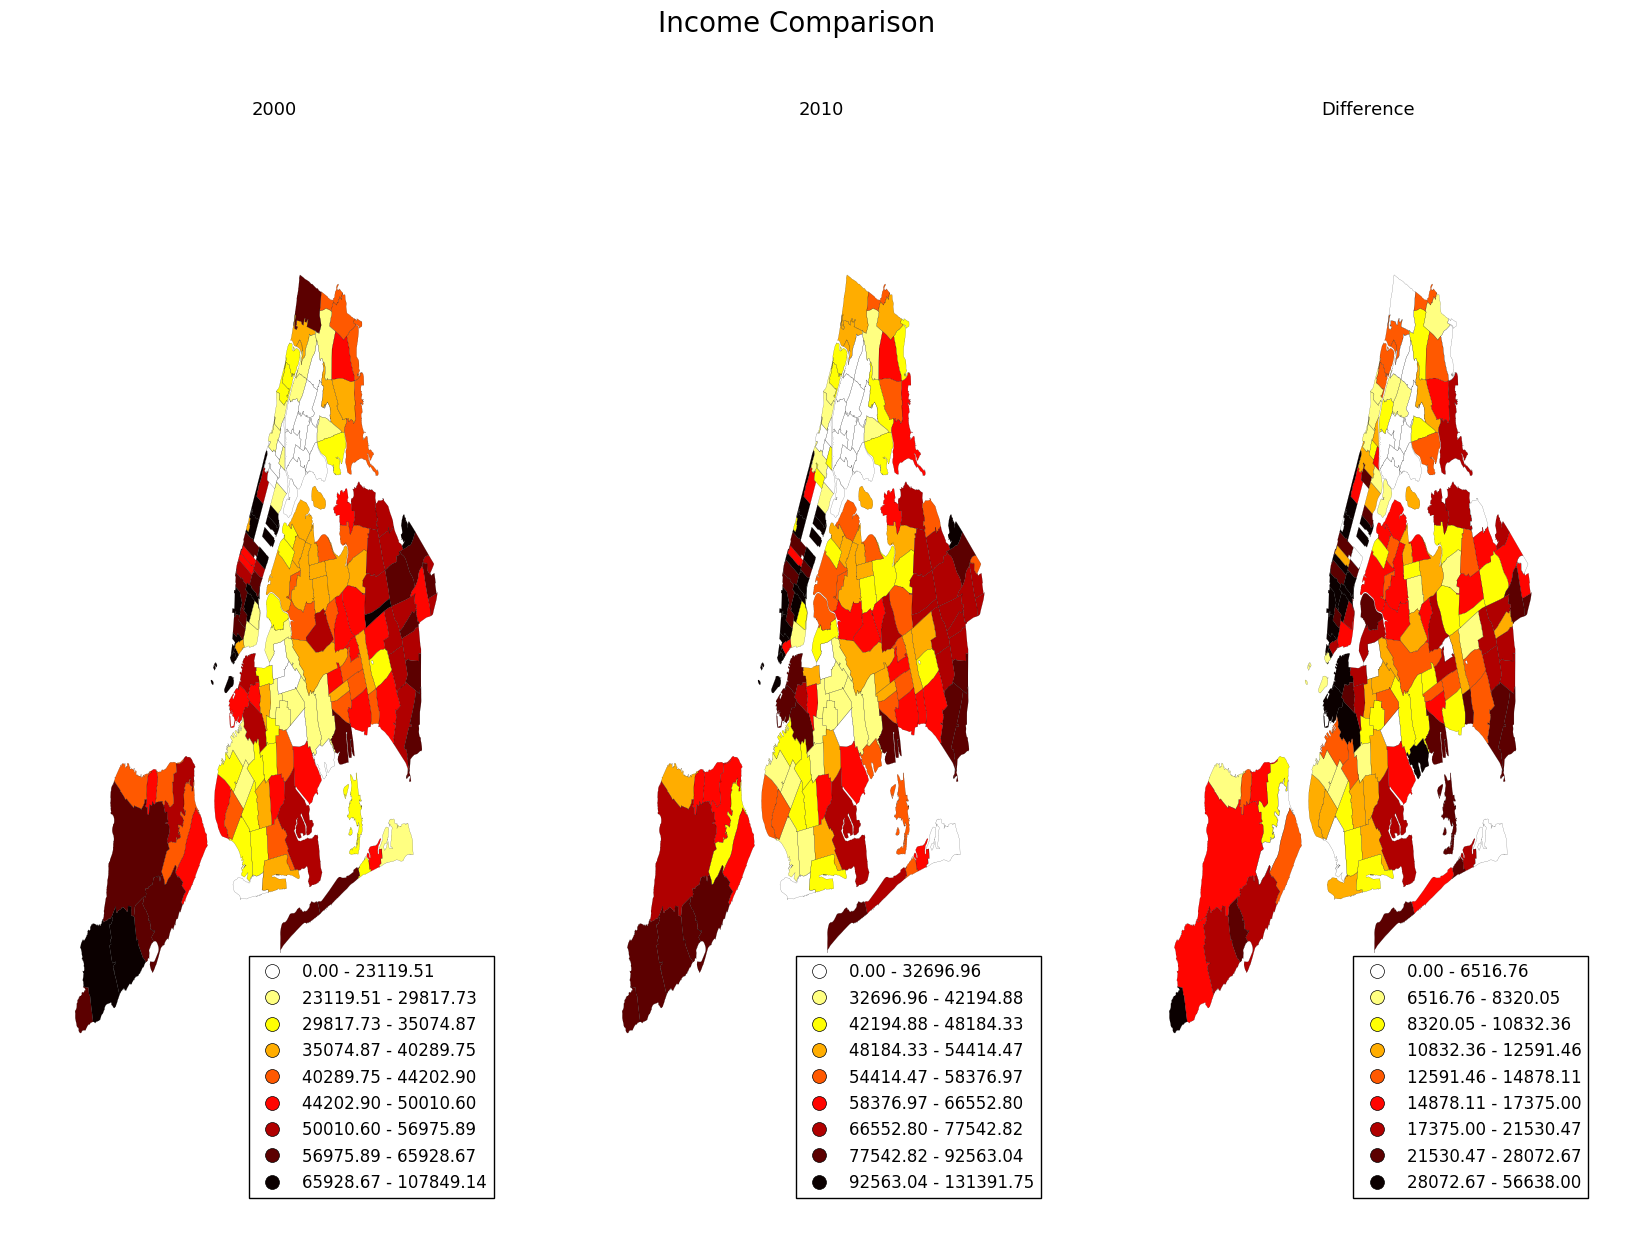

In [56]:
fig = plt.figure(figsize=(20,14))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133) 
choropleth_quantiles(zip_conciled[zip_conciled.income_00.notnull()],column ='income_00', 
                     quantiles = 9, cmap='hot_r',ax= ax1)
ax1.set_title('2000', fontsize = 13)

choropleth_quantiles(zip_conciled[zip_conciled.income_10.notnull()],column ='income_10', 
                     quantiles = 9, cmap='hot_r',ax= ax2)
ax2.set_title('2010', fontsize = 13)

choropleth_quantiles(zip_conciled[zip_conciled.income_diff.notnull()],column ='income_diff', 
                     quantiles = 9, cmap='hot_r',ax= ax3)
ax3.set_title('Difference', fontsize = 13)

fig.suptitle('Income Comparison', fontsize = 20)

### Figure 13: Median Income Change by zip codes from 2000 to 2010
High Median income increase is observed in midtown Manhattan, lower Manhattan, areas near downtown Brooklyn. In genaral the median income has increased as seen from the quantiles which have been created


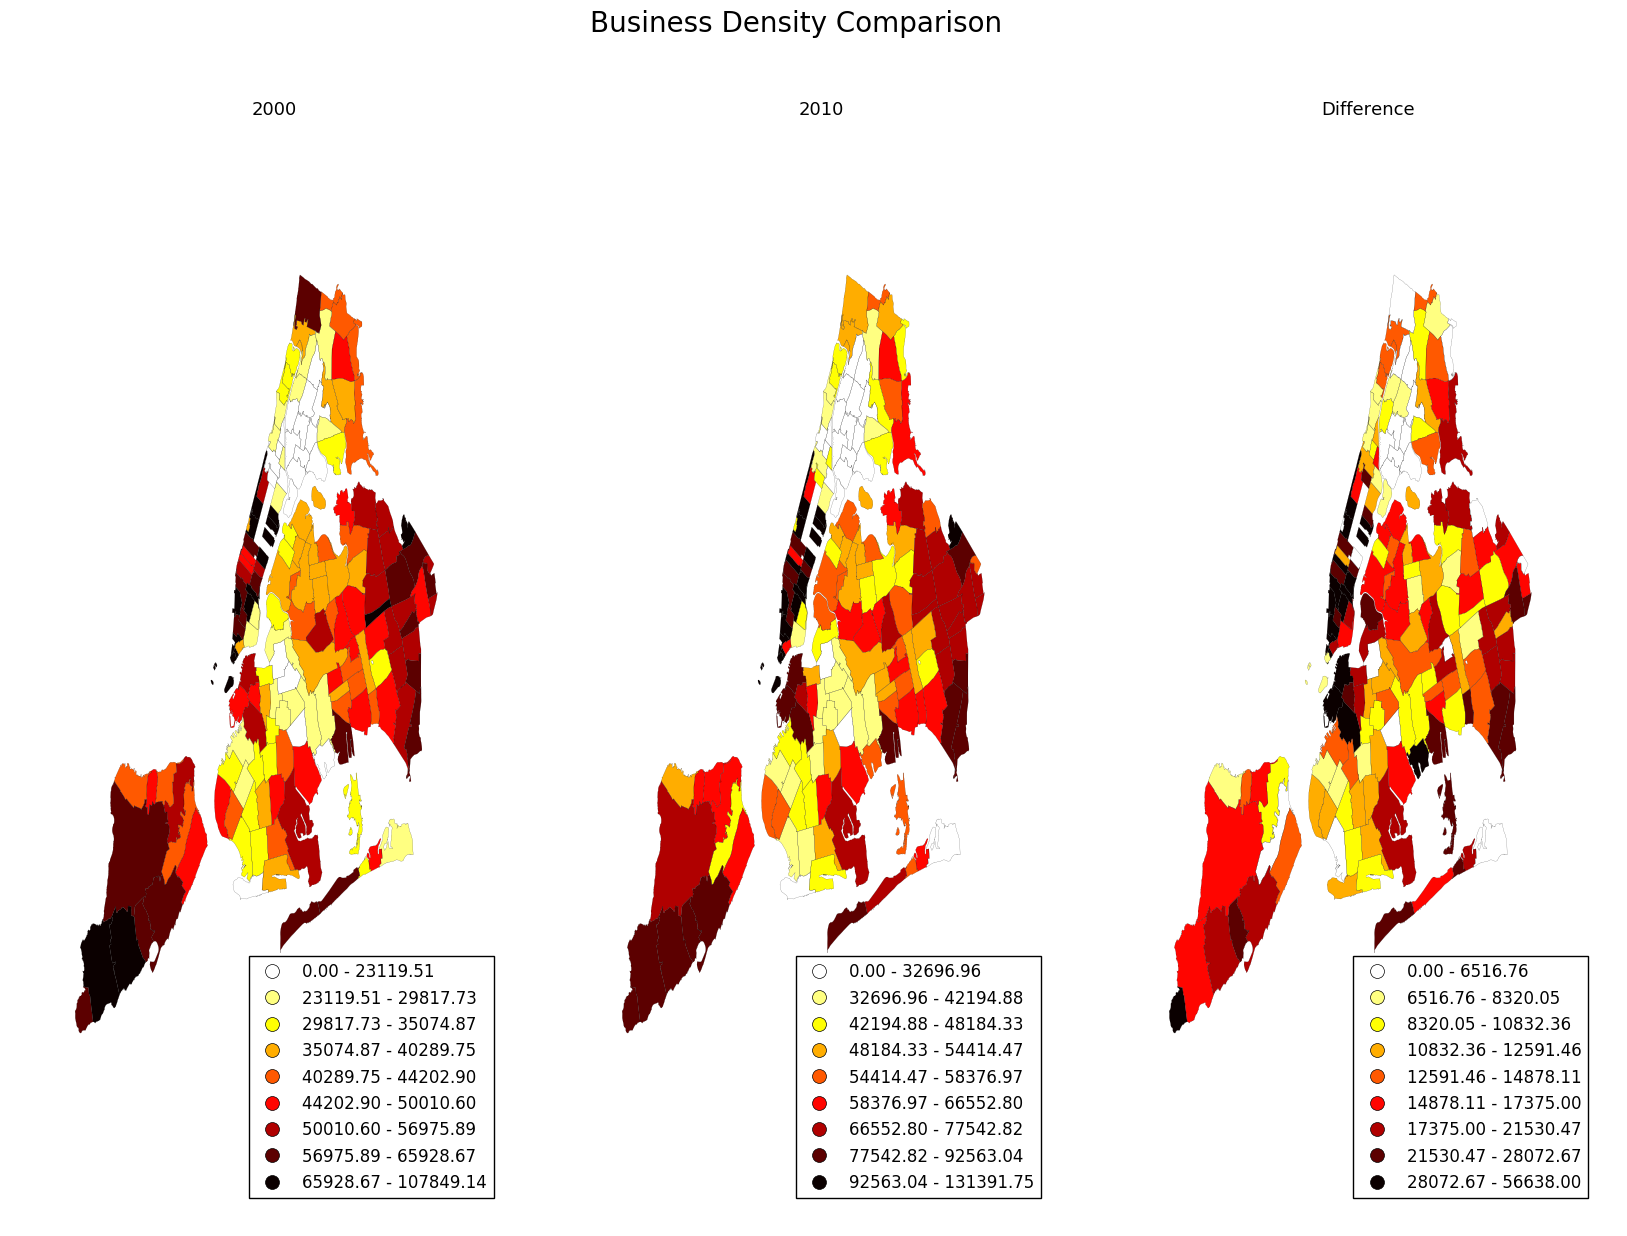

In [57]:
fig = plt.figure(figsize=(20,14))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133) 
choropleth_quantiles(zip_conciled[zip_conciled.density_2000.notnull()],column ='income_00', 
                     quantiles = 9, cmap='hot_r',ax= ax1)
ax1.set_title('2000', fontsize = 13)

choropleth_quantiles(zip_conciled[zip_conciled.density_2010.notnull()],column ='income_10', 
                     quantiles = 9, cmap='hot_r',ax= ax2)
ax2.set_title('2010', fontsize = 13)

choropleth_quantiles(zip_conciled[zip_conciled.density_diff.notnull()],column ='income_diff', 
                     quantiles = 9, cmap='hot_r',ax= ax3)
ax3.set_title('Difference', fontsize = 13)

fig.suptitle('Business Density Comparison', fontsize = 20)

### Figure 14: Business Density by zip codes from 2000 to 2010 in NYC
The business increase is seen is areas of midtown manhattan near highline, downtown brooklyn. Some missing values while aggregating the data may have lead to some mis-representations

# 11 -b) Cluster the Zip Codes

## Cleaning the data

In [58]:
zips2000 = zip_conciled.as_matrix(columns=['age_00', 'population_00', 'diversity_00',
                                           'income_00', 'density_2000'])
zips2010 = zip_conciled.as_matrix(columns=['age_10', 'population_10', 'diversity_10', 
                                           'income_10', 'density_2010'])

In [59]:
# Removing Nan's
cleanzip2000 = zips2000[std(zips2000, axis= 1)>0]
cleanzip2010 = zips2010[std(zips2010, axis= 1)>0]

cleannyzips00 = np.array(zip_conciled.ZIPCODE)[std(zips2000, 1)>0]
cleannyzips10 = np.array(zip_conciled.ZIPCODE)[std(zips2010, 1)>0]

In [60]:
# Whitening the data
wzips00 = whiten(cleanzip2000)
wzips10 = whiten(cleanzip2010)

## Clustering

In [61]:
nc = 5
km00z = KMeans(nc, random_state=444)
km00z.fit(wzips00)

clusters00 = gp.GeoDataFrame()
clusters00['ZIPCODE'] = cleannyzips00
clusters00['cluster00'] = km00z.labels_

zips_cluster = pd.merge(zip_conciled, clusters00, on='ZIPCODE', how='left')

In [62]:
nc = 5
km10z = KMeans(n_clusters=nc, init= km00z.cluster_centers_, random_state=444)
km10z.fit(wzips10)

clusters10 = gp.GeoDataFrame()
clusters10['ZIPCODE'] = cleannyzips10
clusters10['cluster10'] = km10z.labels_

zips_cluster = pd.merge(zips_cluster, clusters10, on='ZIPCODE', how='left')

# 11 -c) 9) Identify the zip codes that have changed cluster assignment and plot

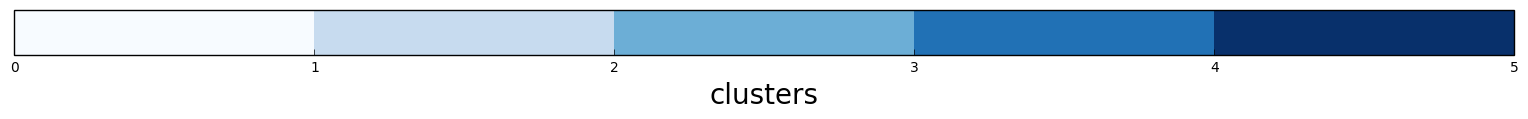

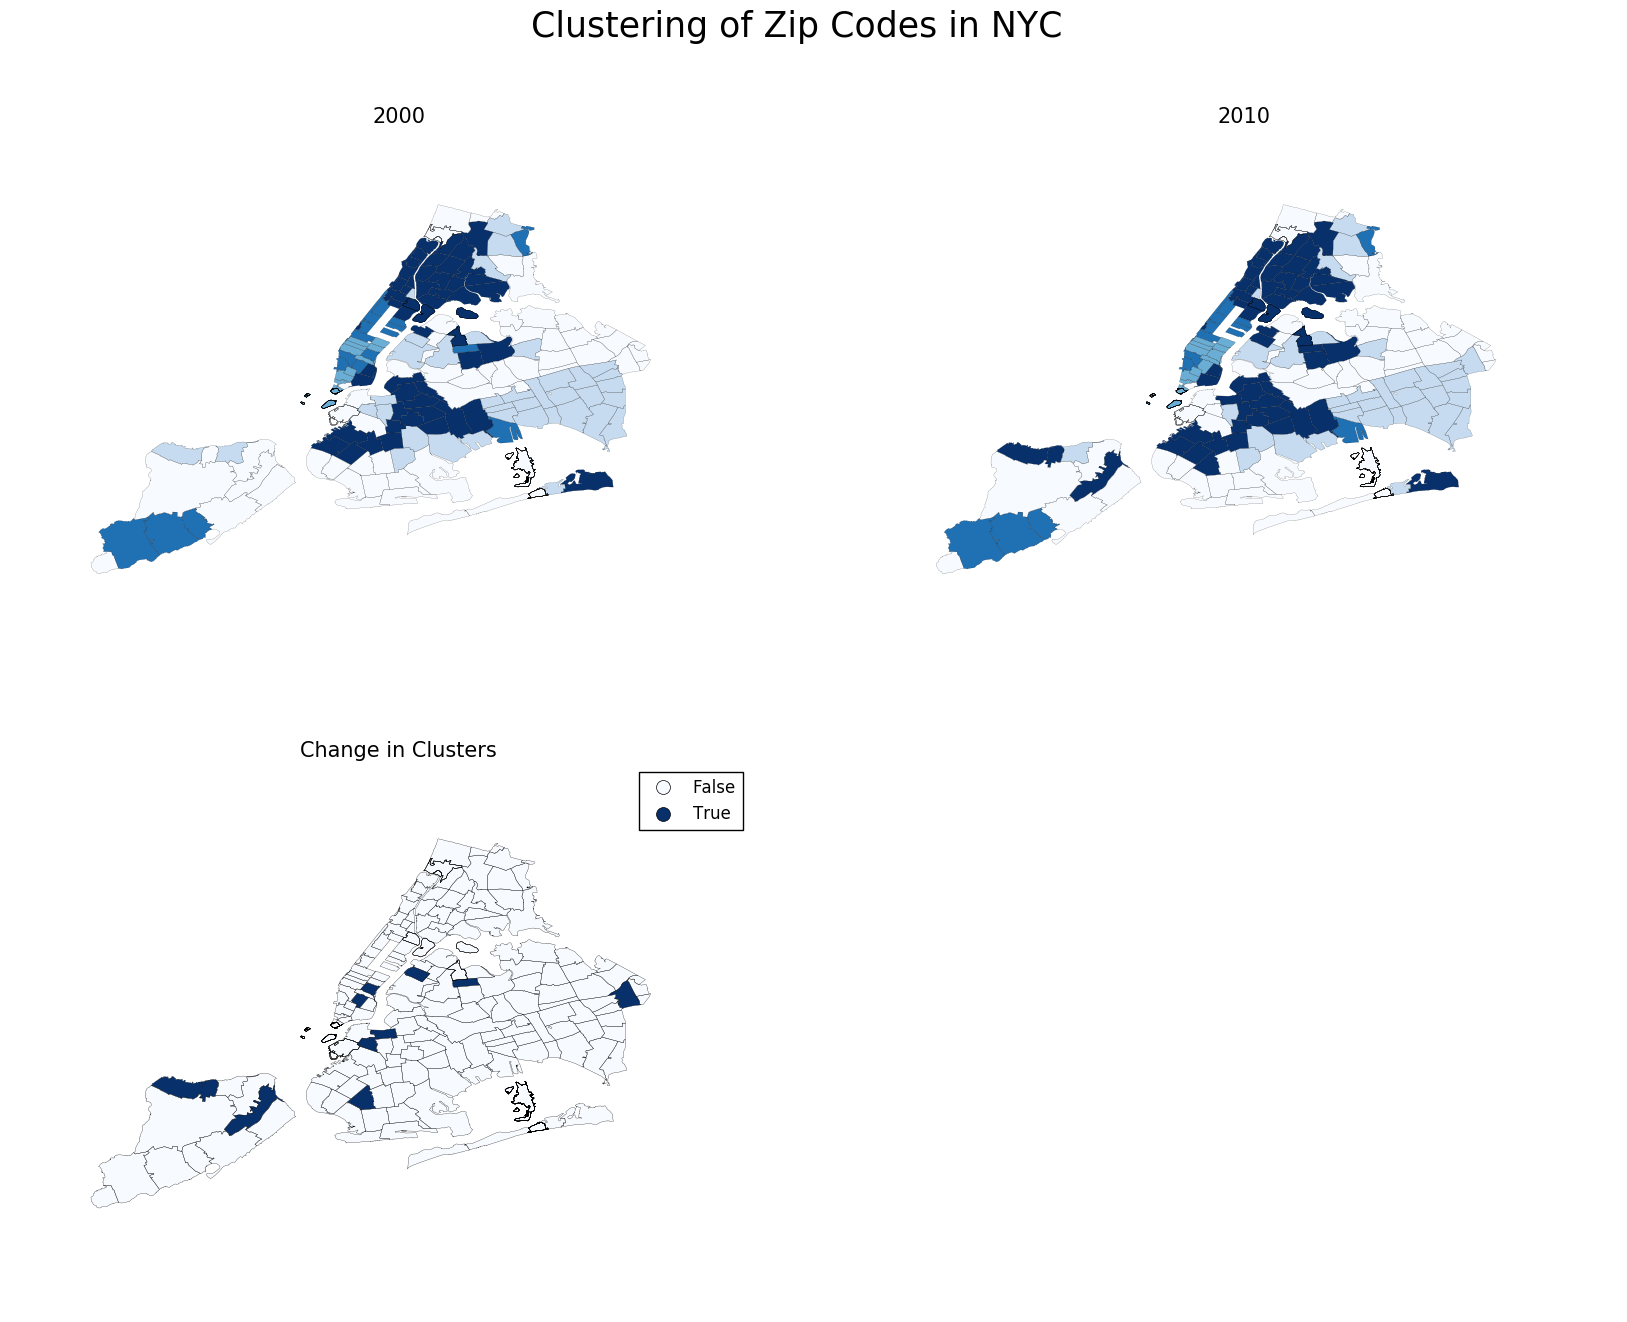

In [63]:
zips_cluster.dropna(inplace= True)
zips_cluster['change'] = zips_cluster.cluster00 != zips_cluster.cluster10

# Code taken from fb55
fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=5)

bounds = range(nc + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='horizontal')
cb3.set_label('clusters', fontsize=20)

fig = plt.figure(figsize=(20,15))
ax2, ax3, ax4 = fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223)

zips_cluster[zips_cluster.cluster00.notnull()].plot(column='cluster00', 
                                              cmap='Blues', alpha = 1, linewidth=0.1, ax=ax2)
ax2.axis('off')
ax2.set_title('2000', fontsize=15)

zips_cluster[zips_cluster.cluster10.notnull()].plot(column='cluster10', 
                                              cmap='Blues', alpha = 1, linewidth=0.1, ax=ax3)
ax3.axis('off')
ax3.set_title('2010', fontsize=15)

zips_cluster.plot(categorical = True, column = 'change', alpha = 1, linewidth=0.2, 
                    cmap='Blues', ax= ax4, legend = True)
ax4.set_axis_off()
ax4.set_title('Change in Clusters', fontsize=15)

fig.suptitle('Clustering of Zip Codes in NYC', fontsize = 25)

### Figure 15: Clustering of zipcodes depending on income, diversity, population, age and business density features
The clustering patterns remain almost similar from 2000 to 2010. There are some zip codes which show change in their clusters as seen in the map above. This maybe because of the change in the features considered for analysis. 

In [64]:
print 'Zipcode counts in clusters in 2000:\n', zips_cluster.cluster00.value_counts()

Zipcode counts in clusters in 2000:
0    132
2     76
4     64
1     39
3     17
Name: cluster00, dtype: int64


In [65]:
print 'Zipcode counts in clusters in 2010:\n', zips_cluster.cluster10.value_counts()

Zipcode counts in clusters in 2010:
0    129
2     78
4     71
1     36
3     14
Name: cluster10, dtype: int64


In [66]:
print 'Count of zipcodes which changed :\n', zips_cluster.change.sum()

Count of zipcodes which changed :
11


In [67]:
zips_cluster = zips_cluster[['ZIPCODE', 'income_00', 'income_10','age_00', 'age_10',
                             'population_00', 'population_10', 'density_2000', 'density_2010',
                             'diversity_00', 'diversity_10', 'geometry', 'cluster00', 'cluster10']]
zips_cluster.rename(columns={'density_2000':'density_00', 'density_2010':'density_10'}, inplace= True)

# 12) Function to analyse the change in clusters

Considering threshold at 0.85 for Pearson's r

Cluster 0 to Cluster 4:
Cluster changed for following blocks:
[10302 10304 11204]

Feature income:
Pearson's r is  0.928601507631
p-value is 0.242023838446

Feature age:
Pearson's r is  0.987444683843
p-value is 0.100986748429

Feature population:
Pearson's r is  0.848479009387
p-value is 0.355037539584
The feature has significantly changed since its r < 0.85

Feature diversity:
Pearson's r is  0.900261385075
p-value is 0.286750595158

Feature density:
Pearson's r is  0.999852232946
p-value is 0.0109443324434


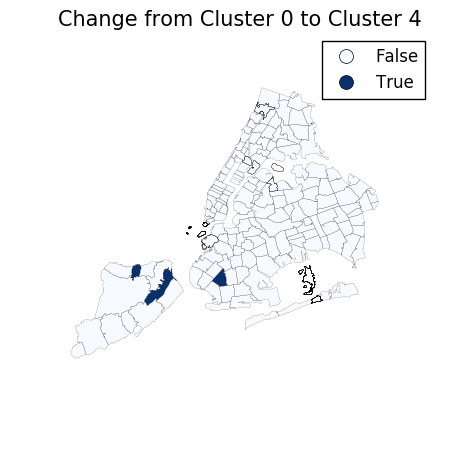

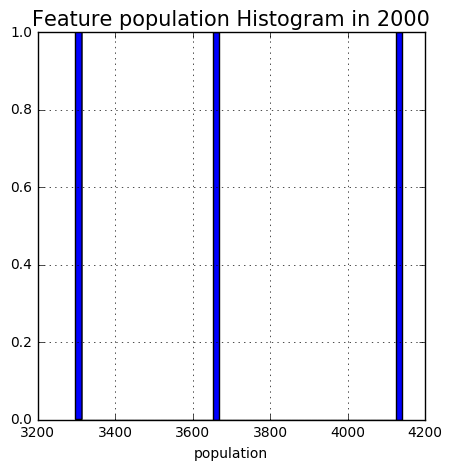

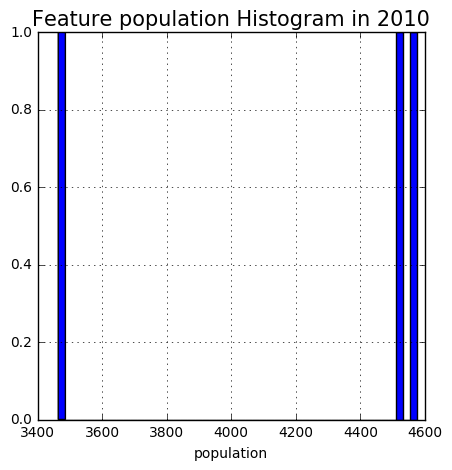

In [68]:
cluster_change(df=zips_cluster, id_column='ZIPCODE', column_2000='cluster00', 
               column_2010='cluster10', label1= 0, label2=4)

### Figure 16: Map of zipcodes that changed from cluster 0 to cluster 4 and histograms of the feature "Population" that changed significantly 

### Comments: 
3 zipcodes changed clusters. To evaluate the factors that changed significantly (which led to this cluster change) I used the Pearson's coefficient test which calculates the linear relationship between the feature's distributions. 

The scipy function used calculates the Pearson correlation coefficient and the p-value for testing non-correlation. 

I chose the threshold value of 0.85 for significance arbritarily. 

The p-value returned by the scipy function is  not entirely reliable but are probably reasonable for datasets larger than 500 or so. The datapoints in the above evaluation are only 3 so the p-value is not useful.

The dataset considered is small and has more statistical noise.


Considering threshold at 0.85 for Pearson's r

Cluster 2 to Cluster 0:
Cluster changed for following blocks:
['1400000US36081000100' '1400000US36061012500' '1400000US36047017100'
 '1400000US36081092900' '1400000US36047007700' '1400000US36061003900'
 '1400000US36085014700' '1400000US36061014601' '1400000US36047006900'
 '1400000US36047013300' '1400000US36047015100' '1400000US36047015300'
 '1400000US36047015500' '1400000US36047074400' '1400000US36061004200'
 '1400000US36047013500' '1400000US36061009500' '1400000US36047014900'
 '1400000US36061013100' '1400000US36061000700' '1400000US36061001300'
 '1400000US36061012900' '1400000US36061010900' '1400000US36047002100'
 '1400000US36085017007' '1400000US36061005800' '1400000US36085024800'
 '1400000US36085027704' '1400000US36061009900']

Feature income:
Pearson's r is  0.600871164147
p-value is 0.000567276119282
The feature has significantly changed since its r < 0.85

Feature age:
Pearson's r is  0.723592872129
p-value is 9.17854824263e-06
The f

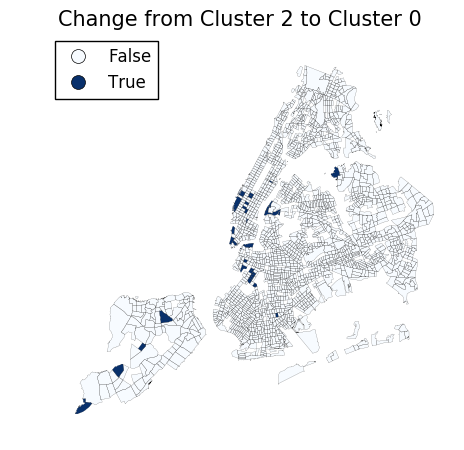

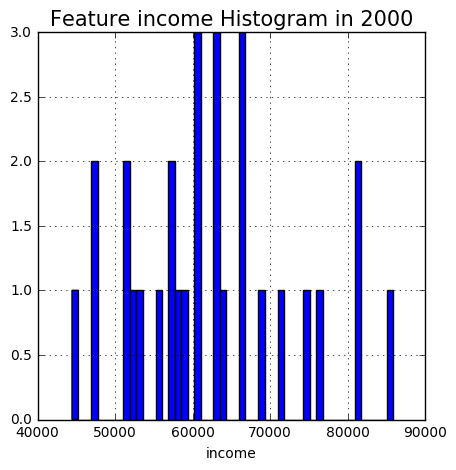

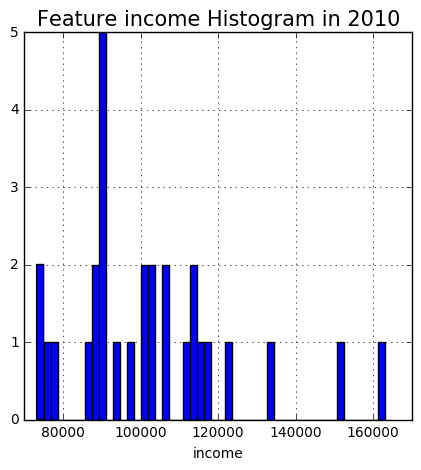

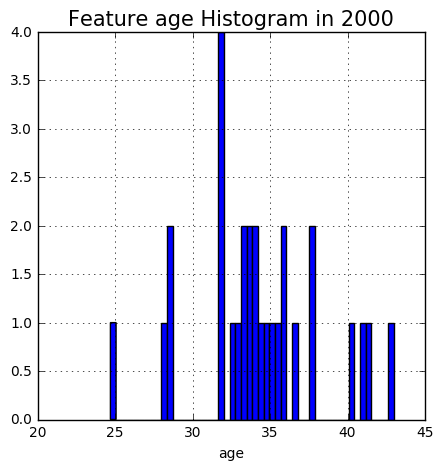

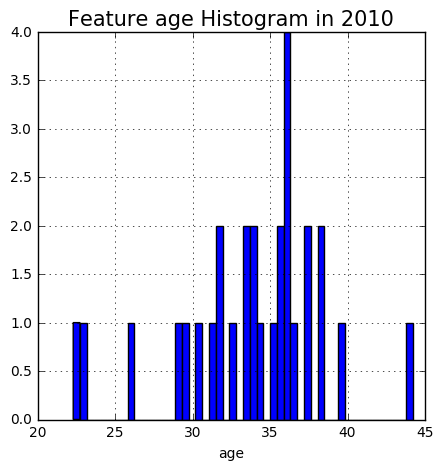

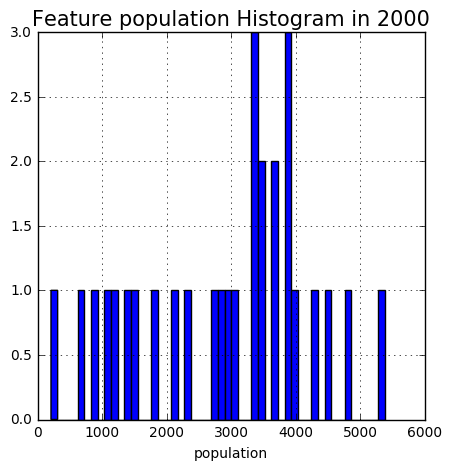

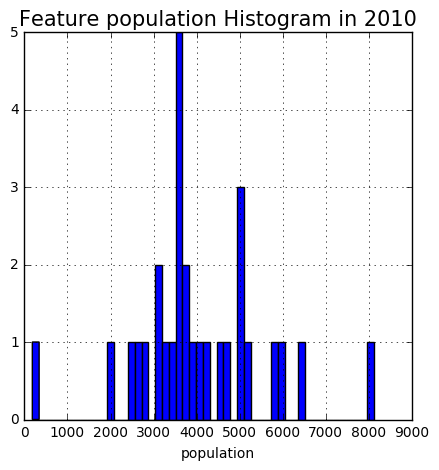

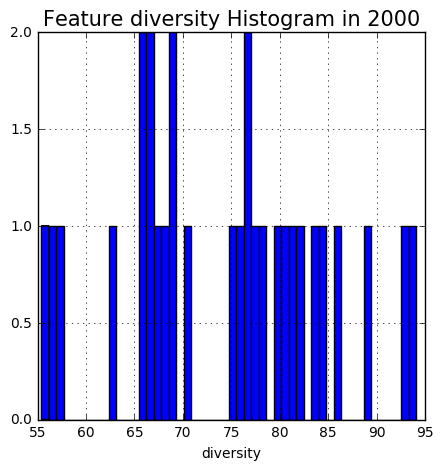

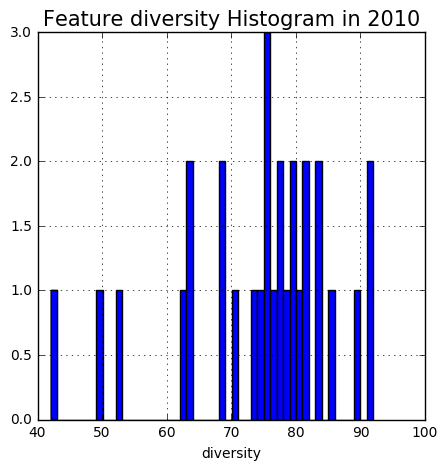

In [69]:
cluster_change(df=census_cluster, id_column='geo_id', column_2000='cluster00', 
               column_2010='cluster10', label1= 2, label2 = 0)

### Figure 17: Map of census tracts that changed from cluster 2 to cluster 0 and histograms of the features that changed significantly 

### Comments: 
The clusters which have changed are unique. The areas near high-line and downtown Brooklyn has gone through some economical changes from 2000 to 2010.

To evaluate the factors that changed significantly (which led to this cluster change) I used the Pearson's coefficient test which calculates the linear relationship between the feature's distributions. 

The scipy function used calculates the Pearson correlation coefficient and the p-value for testing non-correlation. 

I chose the threshold value of 0.85 for significance arbritarily. 

The p-value returned by the scipy function is  not entirely reliable but are probably reasonable for datasets larger than 500 or so. The datapoints in the above evaluation are only 6 so the p-value is not useful.

The dataset considered is small and has more statistical noise.


In [70]:
cluster_change(df=census_cluster, id_column='geo_id', column_2000='cluster00', 
               column_2010='cluster10', label1= 0, label2=1)

Considering threshold at 0.85 for Pearson's r

Cluster 0 to Cluster 1:
No cluster change



Considering threshold at 0.85 for Pearson's r

Cluster 0 to Cluster 2:
Cluster changed for following blocks:
['1400000US36081091601' '1400000US36085015603' '1400000US36047000100'
 '1400000US36005051600' '1400000US36047062800' '1400000US36081094500'
 '1400000US36085011201' '1400000US36085015602' '1400000US36085013204'
 '1400000US36085012100' '1400000US36061010200' '1400000US36061011402'
 '1400000US36081069702' '1400000US36081152902' '1400000US36081157901'
 '1400000US36081101700' '1400000US36061011401' '1400000US36081150701'
 '1400000US36061000900' '1400000US36081133300' '1400000US36081161700'
 '1400000US36085027702' '1400000US36081092200' '1400000US36085013400'
 '1400000US36081047600' '1400000US36005032300' '1400000US36061011202']

Feature income:
Pearson's r is  0.364591294801
p-value is 0.0615152022526
The feature has significantly changed since its r < 0.85

Feature age:
Pearson's r is  0.89430917308
p-value is 3.24936444503e-10

Feature population:
Pearson's r is  0.982573731208
p-v

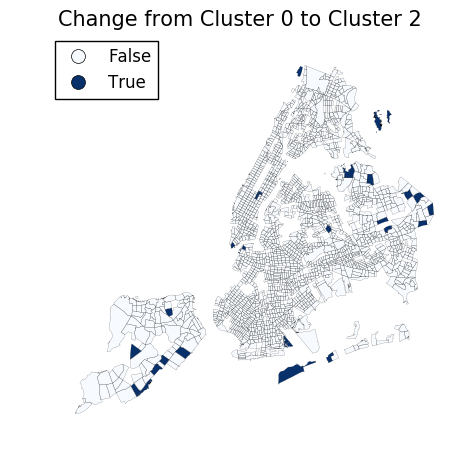

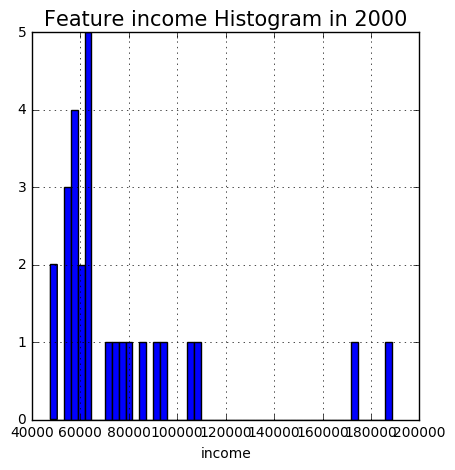

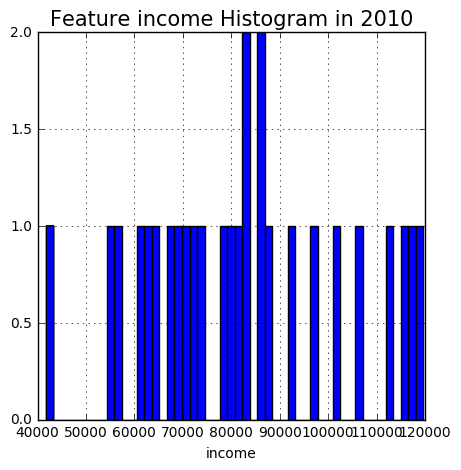

In [71]:
cluster_change(df=census_cluster, id_column='geo_id', column_2000='cluster00', 
               column_2010='cluster10', label1= 0, label2=2)

### Figure 18: Map of census tracts that changed from cluster 0 to cluster 2 and histograms of the features that changed significantly 

### Comments: 
To evaluate the factors that changed significantly (which led to this cluster change) I used the Pearson's coefficient test which calculates the linear relationship between the feature's distributions. 

The scipy function used calculates the Pearson correlation coefficient and the p-value for testing non-correlation. 

I chose the threshold value of 0.85 for significance arbritarily. 

The p-value returned by the scipy function is  not entirely reliable but are probably reasonable for datasets larger than 500 or so. The datapoints in the above evaluation are less than 500 so the p-value is not useful.

The dataset considered is small and has more statistical noise.


# 13) Conclusions

The goal is to identify NYC neighborhoods that are homogeneous by clustering their socioeconomic characteristics in 2000, and in 2010, and find the neighborhoods that change cluster, indicating that they evolve differently with respect to their cluster peers.

The analysis was done at census tract and zipcode level. The socioecnomic characteristics considered are median income, median age, population, business established densitty and for diversity the percentage of white population.

The business density has increased in areas like downtown brooklyn, south brooklyn, upper east, west sides of manhattan as seen in figure 1. 

The analysis done to do a longitudinal study; evolution of neighborhoods in time. This is done by clustering the census tracts  using features like age, income, population and diversity in year 2000 and 2010. The clustering did show some patterns. As seen in figure 8. Areas near downtown Brooklyn, High-Line, northern part of Bronx have actually developed economically from 2000 to 2010. The clustering shows the same.

However, there are some weaknesses with the analysis:
The census tracts shapes considered are from 2010, however the census tracts changed from 2000 to 2010. This lead to some missing values.

The census tracts were later spatially joined to the zipcodes. There were some census tracts which were part of more than one zipcode however, while aggregating the census tracts to zipcodes, the centroids of the census tracts were considered. A weigheted aggregation by considering the proportions of census tracts in the zipcodes would lead to more correct analysis.

The population is aggregated to the zipcode level by taking mean, however the population should have been aggregated by the sum or the mean of population density of the census tracts could lead to better results ion analysis.

The missing census tracts also lead to furture biases in the zipcode clustering. A more careful analysis with care taken to avoid the missing values would help in roboust analysis.

The clustering alogirithm used is K-Means which is not a deterministic algorithm, it depends on the initial points of the cluster centroids. A better analysis would be to reinitialize the K-means for more than 1 time and check for stability. The number of clusters considered are 5 which is chosen arbitrarily. A better way to select the number of clusters would be using the sillehoute score or by using the elbow method.

The study was to check the evolution of nyc neighbourhoods through time, i.e a longitudinal study. A 2 sample t-test could lead to better statistical results, as the statistics of the features are compared at different times for same data.

The pearson's correlation coefficient test which is used, checks if the features of the zipcodes which have changed clusters have linear relation in the two different years viz 2000 and 2010. The value of pearson's coefficient is interpreted as - lpower the 'r', the feature distributions are not linearly correlated, which means the distribiutions of the features for those zipcodes have changed over time.

The correlation test would work better with more datapoints i.e it will work better at a smaller level, the census tracts than the zipcode where we can have more entries. In the current analysis, there are missing values and less datapoints; the statistics received are not considered statistically significant. 